In [37]:
import matplotlib.pyplot as plt
import numpy as np
import pprint

from qutip import * 
import os

# Matplotlib Einstellungen gemäß den LaTeX-Caption-Formatierungen
plt.rcParams.update({
#    'text.usetex': True,              # Enable LaTeX for text rendering
#    'font.family': 'serif',           # Use a serif font family
#    'font.serif': 'Palatino',         # Set Palatino as the serif font
#    'text.latex.preamble': r'\usepackage{amsmath}',
#    'font.size': 20,                   # Font size for general text
#    'axes.titlesize': 20,              # Font size for axis titles
#    'axes.labelsize': 20,              # Font size for axis labels
#    'xtick.labelsize': 20,             # Font size for x-axis tick labels
#    'ytick.labelsize': 20,             # Font size for y-axis tick labels
#    'legend.fontsize': 20,             # Font size for legends
#    'figure.figsize': [8, 6],          # Size of the plot (width x height)
#    'figure.autolayout': True,         # Automatic layout adjustment
#    'savefig.format': 'svg',           # Default format for saving figures
#    'figure.facecolor': 'none',        # Make the figure face color transparent
#    'axes.facecolor': 'none',          # Make the axes face color transparent
#    'savefig.transparent': True        # Save figures with transparent background
})
output_dir = r"C:\Users\leopo\OneDrive - UT Cloud\Uni\Semester_9\Master_thesis\Figures_From_Python"
os.makedirs(output_dir, exist_ok=True)

# allows for interactive plots
#%matplotlib notebook

$$
H = H_0 + H_I
$$
$$
H_0 = \hbar  \omega_a \sum_{i=1}^{N_{\text{atoms}}} \sigma_+^{(i)} \sigma_-^{(i)}
+ \hbar \sum_{i,j=1}^{N_\text{{atoms}}} J_{i j} \sigma_+^{(i)} \sigma_-^{(j)}
$$

$$
H_I = \hbar \Sigma_x E(t).
$$

$$
\displaystyle J_{i j} = \frac{\alpha}{|r_i-r_j|}.
$$

In [60]:
# Set the system parameters
n_rings = 1
n_chains = 1 # number of chains
N_atoms = n_chains * n_rings  # number of atoms

fixed_lam = 1.                # energysplitting of the atom, when ground state is set to 0
omega_a = 2 * np.pi / fixed_lam # actually k_a
omega_c = omega_a
distance = 1 * fixed_lam # defining topology                                    0.1 <--

gamma_0 = .1   # decay rate of the atoms
gamma_phi = .0 # dephasing rate of the atoms

alpha = 1. # coupling strength of the dipoles       Fine structure const?

# evolution
t_max = 10
time_steps = 10
t_step_width = t_max / time_steps
times = np.linspace(0, t_max, time_steps) # list of times
Ts = np.linspace(0, t_max, 3)

def count_decimal_digits(number):
    # Convert the number to string
    str_number = str(number)

    # Split the string at the decimal point and count the digits after it
    if '.' in str_number:
        return len(str_number.split('.')[1])
    else:
        return 0  # No digits after decimal if it's an integer

tolerance = count_decimal_digits(times[1]) - 2
tol = 10**-tolerance

In [61]:
########################################               define the geometry                 #############################################
def chain_positions(distance, N_atoms):
    Pos = np.zeros((N_atoms, 3))
    for i in range(N_atoms):
        Pos[i, 2] = i * distance
    return Pos

def z_rotation(angle):
    return np.array([
        [np.cos(angle), -np.sin(angle), 0],
        [np.sin(angle),  np.cos(angle), 0],
        [0,              0,            1]])

def ring_positions(distance, n_chains):
    Pos = np.zeros((n_chains, 3))
    dphi = 2 * np.pi / n_chains
    if n_chains == 1:
        radius = 0
    else:
        radius = distance / 2 / np.sin(np.pi / n_chains)
    helper = np.array([radius, 0, 0])
    for i in range(n_chains):
        rotation_matrix = z_rotation(dphi * i)
        Pos[i] = np.matmul(rotation_matrix, helper)
    return Pos

def cyl_positions(distance, N_atoms, n_chains):
    Pos = np.zeros((N_atoms, 3))
    Pos_chain = chain_positions(distance, N_atoms // n_chains)
    Pos_ring = ring_positions(distance, n_chains)
    for i in range(n_chains):
        Pos[i * (N_atoms // n_chains): (i + 1) * (N_atoms // n_chains)] = Pos_chain + Pos_ring[i]
    return Pos

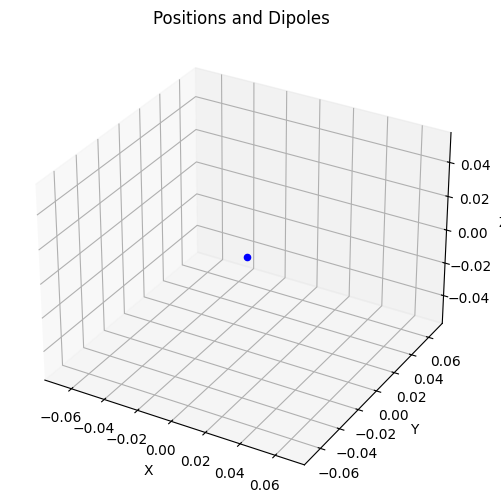

In [62]:
Pos = cyl_positions(distance, N_atoms, n_chains)

# Plotting 
fig = plt.figure(figsize=(8, 6)) 
ax = fig.add_subplot(111, projection='3d') 
# Plot the positions 
ax.scatter(Pos[:, 0], Pos[:, 1], Pos[:, 2], c='b', marker='o') 
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')
ax.set_title('Positions and Dipoles')
ax.axis('equal')
plt.show()

In [63]:
# Define the ground & the excited states
# atomic dofs
atom_g = basis(N_atoms + 1, 0)
atom_es = [basis(N_atoms + 1, i) for i in range(1, N_atoms + 1)]

# combined dofs
sm_list = []    # lowering operators of atomic system
S_x = 0         # collective sigma_x operator for the system

for i in range(N_atoms):
    op = atom_g * atom_es[i].dag()
    sm_list.append(op)
    S_x += op + op.dag()

In [64]:
def Hamilton0(distance, n_rings, n_chains):
    N_atoms = n_chains * n_rings
    Pos = cyl_positions(distance, N_atoms, n_chains)
    H = 0
    for a in range(N_atoms):
        for b in range(N_atoms):
            op = sm_list[a].dag() * sm_list[b]
            if a != b:
                ra, rb = Pos[a, :], Pos[b, :]
                H += alpha / (np.linalg.norm(rb-ra))**3 * op
            else:
                H += omega_a * op # Diagonals except for |0><0|
    return H
    
H0 = Hamilton0(distance, n_rings, n_chains)

H0

Quantum object: dims=[[2], [2]], shape=(2, 2), type='oper', dtype=Dense, isherm=True
Qobj data =
[[0.         0.        ]
 [0.         6.28318531]]

In [65]:
# Jump / Expect Operators
# Define the decay collapse and dephasing operator for each spin

op_list = sm_list  # Operators combining the cavity (qeye(2)) and the atomic lowering operator (sm)

# Collapse operators
c_op2 = [np.sqrt(gamma_0) * op for op in op_list]                         # Individual atom decays
c_op4 = [np.sqrt(gamma_phi) * commutator(op.dag(), op) for op in op_list] # Individual atom dephasing
c_op_list = c_op2 + c_op4  # Combine all collapse operators

# Expectation operators for measuring populations across atomic excited levels
e_op_list = [
    basis(N_atoms + 1, i) * basis(N_atoms + 1, i).dag()
    for i in range(N_atoms + 1)
]

e_op_list

[Quantum object: dims=[[2], [2]], shape=(2, 2), type='oper', dtype=Dense, isherm=True
 Qobj data =
 [[1. 0.]
  [0. 0.]],
 Quantum object: dims=[[2], [2]], shape=(2, 2), type='oper', dtype=Dense, isherm=True
 Qobj data =
 [[0. 0.]
  [0. 1.]]]

In [66]:
# create the time dependant evolution

I = S_x
E12 = 10 # Amplitude of laser pulses 1,2
E0s = [E12, E12, E12/10] # Probe pulse is smaller
omegas = [omega_a, omega_a, omega_a]
Delta_ts = [t_max/100, t_max/100, t_max/100] # narrow width of the pulses
phi12 = 2  * np.pi         # phis = [phi12, phi12, 0]  # Phase-kick?, pulse 1 and 2 are phase locked!

def heaviside(x):
    return 1 if x >= 0 else 0

def El_field(t, args):
    t0 = args['time']
    Delta = args['Delta']
    E = 1 / np.sqrt(2) * args['E0'] * heaviside(Delta - np.abs(t - t0)) * np.cos(np.pi*(t - t0)/(2*Delta))**2 * np.cos(args['omega'] * (t - t0) + args['phi'])
    return E

HI = [-I, El_field] # interaction Hamiltonian with function-based time dependence
H = [H0, HI]

options = Options(store_states=True)

In [67]:
# evolution with t
# initial state
psiini = basis(N_atoms+1, 0) # = |g>_atom

#
# PREPROCESSING
#
# Define the phases, coherence times, and waiting times
phases = [i * np.pi/2 for i in range(4)]

# Initialize the main dictionary to hold the structure
data_dict_stage1 = {}
data_dict_stage2 = {}

# Loop through each phase φ
for phi in phases:
    data_dict_stage1[phi] = {}  # Stage 1 copy of the phase
    data_dict_stage2[phi] = {}  # Stage 2 copy of the phase

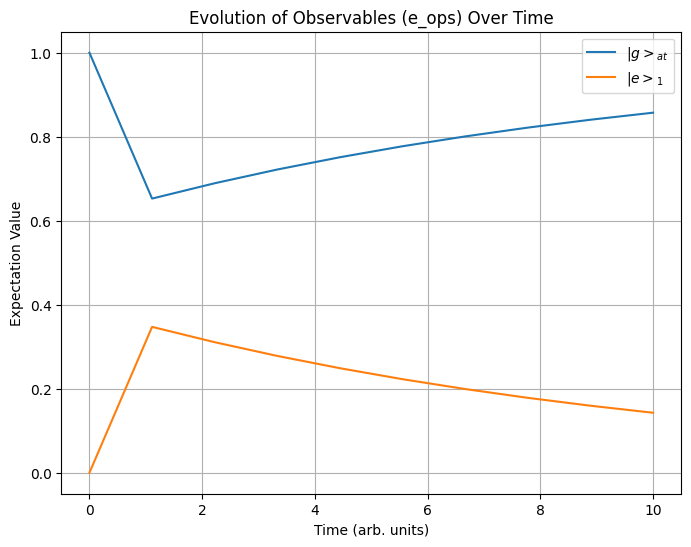

In [68]:
#
# CALCULATIONS
#

# (first laser pulse)
times_0 = times

# Iterate over the phi values
for phi in data_dict_stage1:
    args_0 = {
        'phi': phi12,  # Use the phase 0
        'time': Delta_ts[0],  # t0 value = Delta value such that the pulse immediatley starts
        'omega': omegas[0],  # omega value
        'Delta': Delta_ts[0], # The width should be
        'E0': E0s[0]  # E0 value
    }

    # Solve the system using mesolve (first laser pulse)
    result_0 = mesolve(H, psiini, times_0, c_ops=c_op_list, e_ops=e_op_list, args=args_0, options=options)

    current_dict = {}

    for i in range(len(times_0)): # save only the states that make sense
        if (2 * Delta_ts[0] <= times_0[i] <= t_max - 2 * (Delta_ts[1] + Delta_ts[2])):
            current_dict[i] = result_0.states[i]  # tau is indirectly stored in the index i (key of the dictionary)

    if current_dict:  # Check if the dictionary is not empty
        data_dict_stage1[phi] = current_dict

#
# PLOT TO CHECK the evolution
#
# Plot each observable in `e_ops`
plt.figure(figsize=(8, 6))
for i, e_op_expect in enumerate(result_0.expect):
    if i ==0:
        label=r"$|g>_{at}$"
    else:
        label=f"$|e>_{i}$"
    plt.plot(result_0.times, e_op_expect, label=label)

# Add labels and legend
plt.xlabel("Time (arb. units)")
plt.ylabel("Expectation Value")
plt.title("Evolution of Observables (e_ops) Over Time")
plt.legend()
plt.grid()
plt.show()
#pprint.pprint(data_dict_stage1)

In [69]:
# (second laser pulse)
# Iterate over the phi values
for phi, dic in data_dict_stage1.items():
    # Iterate over the tau values and states after tau, from there make the second laser pulse
    for i, psiini_1 in dic.items():
        times_1 = times[i:]
        args_1 = {
            'phi': phi12,
            'time': times_1[0] + Delta_ts[1],
            'omega': omegas[1],
            'Delta': Delta_ts[1],
            'E0': E0s[1]
        }

        # Solve the system using mesolve (second laser pulse)
        result_1 = mesolve(H, psiini_1, times_1, c_ops=c_op_list, e_ops=e_op_list, args=args_1, options=options)

        '''        # Generate time array
        t = np.array(times_1)

        # Compute electric field values
        E = np.array([El_field(time, args_1) for time in t])

        # Plot the electric field
        plt.figure(figsize=(8, 6))
        plt.plot(t, E, label="Electric Field (E(t))")
        plt.xlabel("Time (t)")
        plt.ylabel("Electric Field (E(t))")
        plt.title("Electric Field Plot for Second Laser Pulse")
        plt.grid()
        plt.legend()
        plt.show()'''

        current_dict = {}
        for j in range(len(times_1)): # save only the states that make sense
            if (times[i] + 2 * Delta_ts[1] <= times_1[j] <= t_max - 2 * Delta_ts[2]):
                current_dict[j] = result_1.states[j] # T is stored in the information j, together with i

        if current_dict:  # Check if the dictionary is not empty
            data_dict_stage2[phi][i] = current_dict
        #
        # PLOT TO CHECK the evolution
        #
        # Plot each observable in `e_ops`
        if phi == 0 and i % 10 == 0:
            plt.figure(figsize=(8, 6))
            for i, e_op_expect in enumerate(result_1.expect):
                if i ==0:
                    label=r"$|g>_{at}$"
                else:
                    label=f"$|e>_{i}$"
                plt.plot(result_1.times, e_op_expect, label=label)

            # Add labels and legend
            plt.xlabel("Time (arb. units)")
            plt.ylabel("Expectation Value")
            plt.title("Evolution of Observables (e_ops) Over Time")
            plt.legend()
            plt.grid()
            plt.show()

# After processing each coherence time, you can optionally print the current state of the dictionary
#pprint.pprint(data_dict_stage2)

In [70]:
# (third laser pulse)
data_dict = {}

# Iterate over the phi values
for phi, dic in data_dict_stage2.items():
    # Iterate over the tau values
    for i, dic1 in dic.items():
        times_1 = times[i:]


        # Iterate over the T values and make the last laser pulse
        for j, psiini_2 in dic1.items():
            waiting_time_j = times_1[j] - times_0[i] + Delta_ts[2] - Delta_ts[1]
            T = round(waiting_time_j, tolerance) # Round to tolearance decimal places carefull!

            # only if the time is in Ts DOES ONLY REDUCE POST-PROCESSING costs
            for T_val in Ts:
                if np.isclose(T, T_val, atol=tolerance):
                    times_2 = times_1[j:]
                    args_2 = {
                        'phi': 0,       #last pulse has no phase kick
                        'time': times_2[0] + Delta_ts[2],  # Duration for the 2nd pulse
                        'omega': omegas[2],  # Omega for the 2nd pulse
                        'Delta': Delta_ts[2],  # Delta for the 2nd pulse
                        'E0': E0s[2]  # E0 for the 2nd pulse
                    }

                    # (last laser pulse)
                    result_2 = mesolve(H, psiini_2, times_2, c_ops=c_op_list, args=args_2, options=options)

                    # Iterate over the states in result_2 and store the ones that meet:
                    # ONLY the first state with T >= times_2[0] + 2 Delta_ts[2] is important -> break
                    for k in range(len(times_2)):
                        if (times_1[j] + 2 * Delta_ts[2] <= times_2[k] <= t_max):
                            if phi not in data_dict:
                                data_dict[phi] = {}

                            if T not in data_dict[phi]:
                                data_dict[phi][T] = {}

                            coherence_time_i = times_0[i] + Delta_ts[1] - Delta_ts[0]
                            tau = round(coherence_time_i, tolerance) # Round to tolearance decimal places carefull!

                            if tau not in data_dict[phi][T]:
                                data_dict[phi][T][tau] = []

                            # store the final time and the final state
                            t = round(times_2[k], tolerance)
                            data_dict[phi][T][tau].append((t, result_2.states[k])) # Round to tolearance decimal places carefull!
        #                   break  # Stop after saving the first v pair

pprint.pprint(data_dict)
# The final data_dict will now contain the results for each φ, τ, and T

{0.0: {np.float64(1.11111111111111): {np.float64(1.11111111111111): [(np.float64(3.33333333333333),
                                                                      Quantum object: dims=[[2], [2]], shape=(2, 2), type='oper', dtype=Dense, isherm=True
Qobj data =
[[0.39363922+8.11599663e-17j 0.35387482+1.17070501e-01j]
 [0.35387482-1.17070501e-01j 0.60636078-8.11599663e-17j]]),
                                                                     (np.float64(4.44444444444444),
                                                                      Quantum object: dims=[[2], [2]], shape=(2, 2), type='oper', dtype=Dense, isherm=True
Qobj data =
[[0.45740454+7.26251288e-17j 0.18524759+3.00008625e-01j]
 [0.18524759-3.00008625e-01j 0.54259546-7.26251288e-17j]]),
                                                                     (np.float64(5.55555555555556),
                                                                      Quantum object: dims=[[2], [2]], shape=(2, 2), type='oper', dt

In [53]:
#
# POST-PROCESSING
#

# Create an empty dictionary `accumulated_data` to store lists of (\psi) for each ((\tau, T, t)):
accumulated_data = {}
averaged_data_dict = {}

for phi, phi_dict in data_dict.items():
    for T, tau_dict in phi_dict.items():
        if T not in averaged_data_dict:
            averaged_data_dict[T] = {}
        for tau, T_list in tau_dict.items():
            if tau not in averaged_data_dict[T]:
                averaged_data_dict[T][tau] = {}

            for t, psi in T_list:
                # Create a key for the current combination
                key = (T, tau, t)
                # Add psi to the list for this combination
                if key not in accumulated_data:
                    accumulated_data[key] = []
                accumulated_data[key].append(psi)


# After accumulating all states (( \psi )) for each ((\tau, T, t)), compute the average and then also the expectation value
# <psi | S_x | psi>

for (T, tau, t), states in accumulated_data.items():
    # Compute the average of the states
    mean_psi = sum(states) / len(states)
    expect_val = expect(S_x, mean_psi)
    # Save the result in averaged_data_dict
    averaged_data_dict[T][tau][t] = expect_val

pprint.pprint(averaged_data_dict)

# this is already in the order:
#     averaged_data_dict = {
#         T1: {
#             tau1: {t1: avg1, t2: avg2, ...},
#             tau2: {t1: avg, t2: avg2, ...},
#             ...
#         },
#         T2: { ... }
#         ...
#     }
# here T1<T2<... and for each case tau1<tau2<... aswell as t1<t2<...
# for a fixed T: taui directly correponds to ti for which i runs from 0 to Steps = time_steps - T_steps = time_steps * (1 - T/t_max)

{np.float64(0.204081632653061): {np.float64(0.204081632653061): {np.float64(0.612244897959184): -0.15244269896611595,
                                                                 np.float64(0.816326530612245): -0.9574808686088039,
                                                                 np.float64(1.020408163265306): -0.3899623869674261,
                                                                 np.float64(1.224489795918367): 0.7184770221914035,
                                                                 np.float64(1.428571428571428): 0.7867829903820436,
                                                                 np.float64(1.63265306122449): -0.26078335859375246,
                                                                 np.float64(1.836734693877551): -0.9177775203871352,
                                                                 np.float64(2.040816326530612): -0.2614478023156756,
                                                                 

In [55]:
# Create an empty dictionary `two_d_array_dict` for 2D arrays
two_d_array_dict = {}

for T, tau_dict in averaged_data_dict.items():
    # Extract unique taus and ts
    unique_taus = sorted(tau_dict.keys())
    unique_ts = sorted(set(t for tau in tau_dict.values() for t in tau.keys()))
    if len(unique_taus) == 1 or len(unique_ts) == 1:
        continue  # Skip this entry
    # Initialize the 2D array
    size = (len(unique_ts), len(unique_taus))
    two_d_array = np.zeros(size)

    # Create mapping of tau, t to their respective indices
    tau_to_index = {tau: i for i, tau in enumerate(unique_taus)}
    t_to_index = {t: j for j, t in enumerate(unique_ts)}

    # Fill the 2D array with the expectation values
    for tau, t_dict in tau_dict.items():
        tau_index = tau_to_index[tau]
        for t, expect_val in t_dict.items():
            t_index = t_to_index[t]
            two_d_array[t_index, tau_index] = expect_val

    # Store the result
    two_d_array_dict[T] = (two_d_array, unique_ts, unique_taus)

#now its sorted:
two_d_array_dict = {T: value for T, value in sorted(two_d_array_dict.items())}
pprint.pprint(two_d_array_dict)
# Now, `two_d_array_dict` contains the 2D arrays for each T

{np.float64(0.204081632653061): (array([[-0.1524427 ,  0.        ,  0.        , ...,  0.        ,
         0.        ,  0.        ],
       [-0.95748087, -0.04349523,  0.        , ...,  0.        ,
         0.        ,  0.        ],
       [-0.38996239, -0.28057871,  0.45790778, ...,  0.        ,
         0.        ,  0.        ],
       ...,
       [-0.0178508 ,  0.17551948, -0.45157194, ...,  0.39447587,
         0.        ,  0.        ],
       [-0.59570617, -0.00443359, -0.36449571, ..., -0.66729621,
         0.42073059,  0.        ],
       [-0.31805659, -0.17447064,  0.23713914, ..., -0.76237735,
        -0.31014105,  0.73134727]], shape=(47, 41)),
                                 [np.float64(0.612244897959184),
                                  np.float64(0.816326530612245),
                                  np.float64(1.020408163265306),
                                  np.float64(1.224489795918367),
                                  np.float64(1.428571428571428),
            

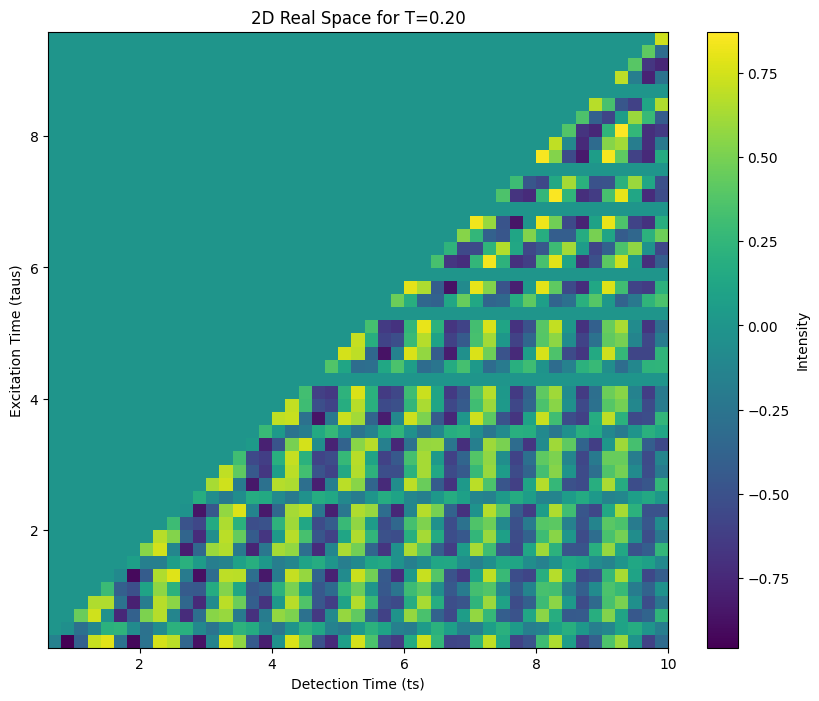

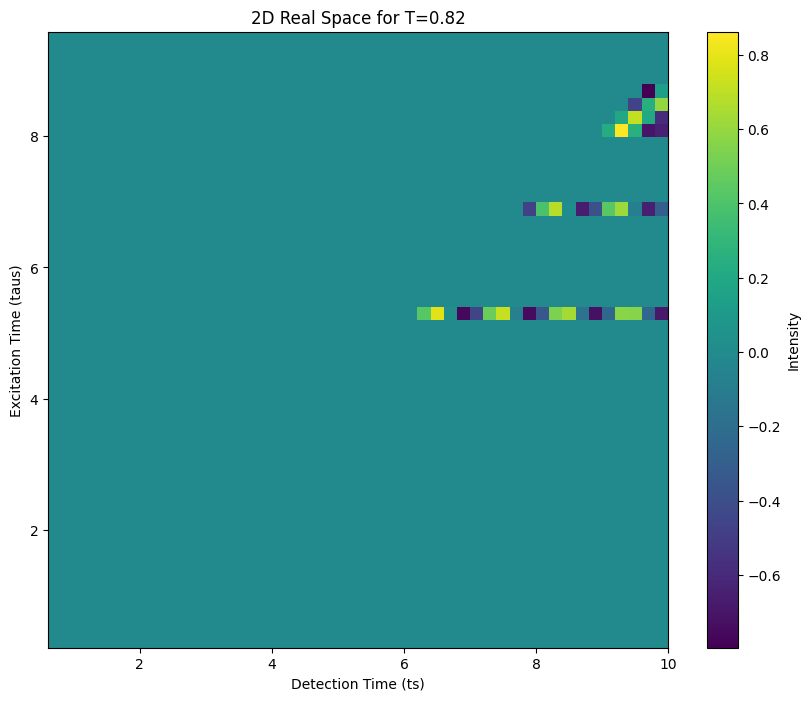

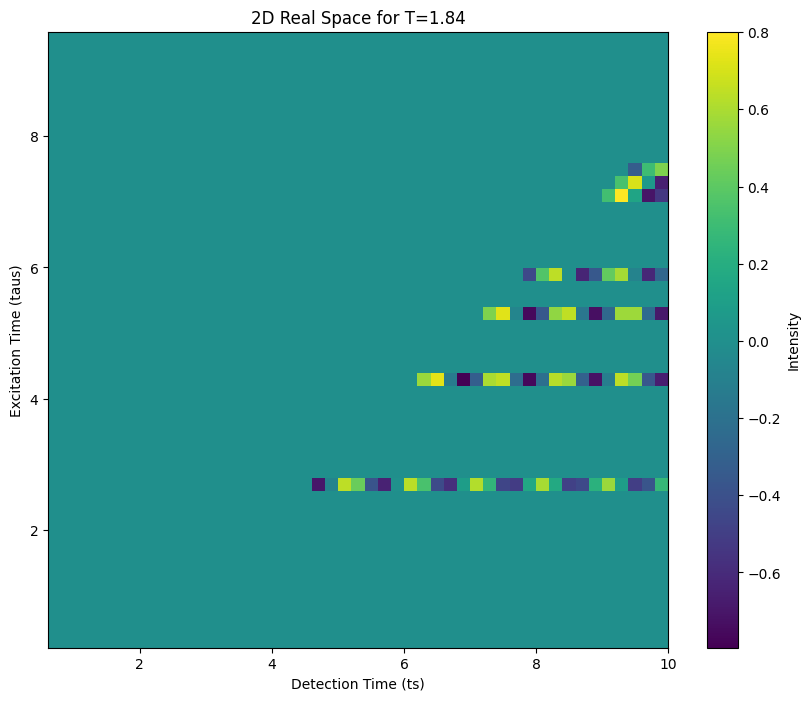

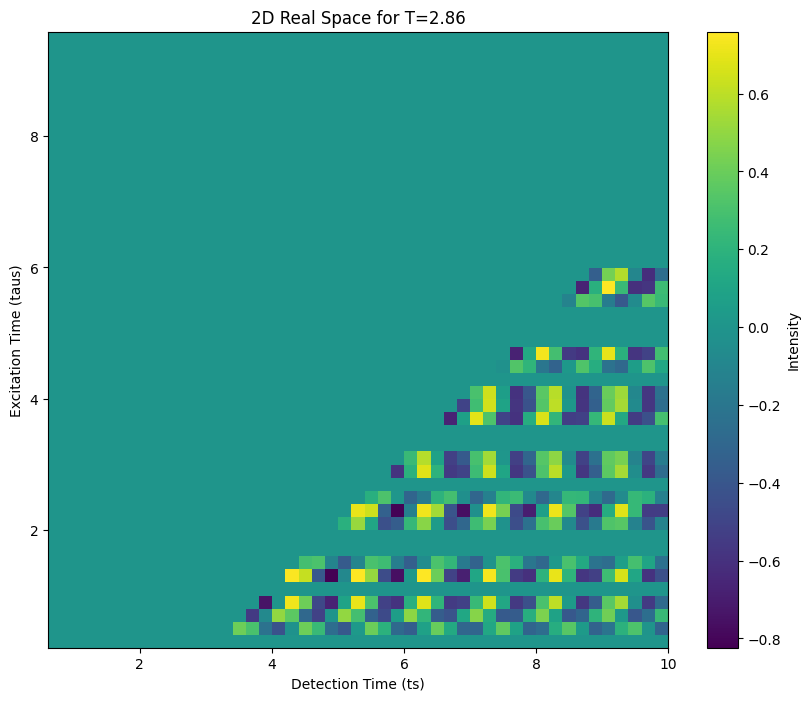

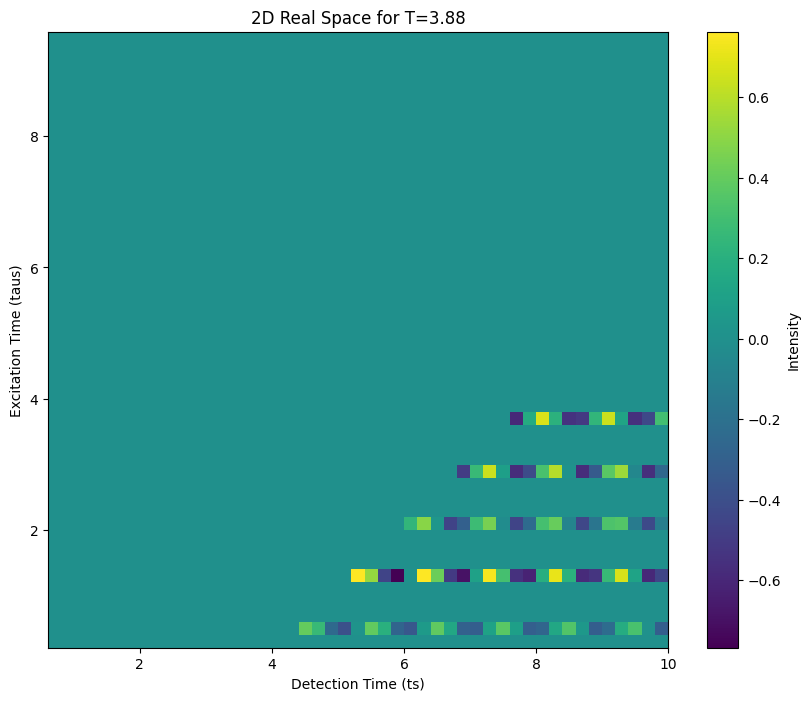

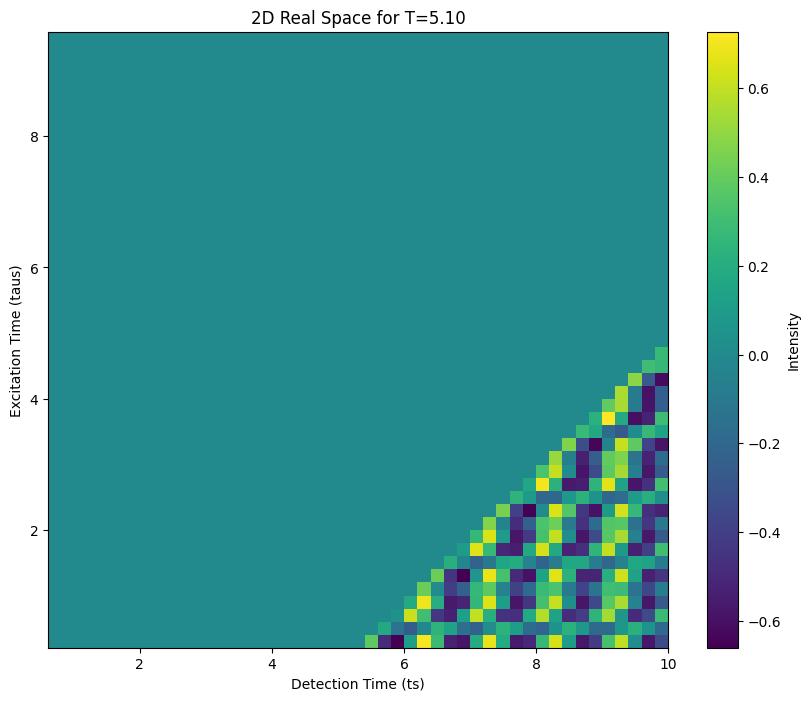

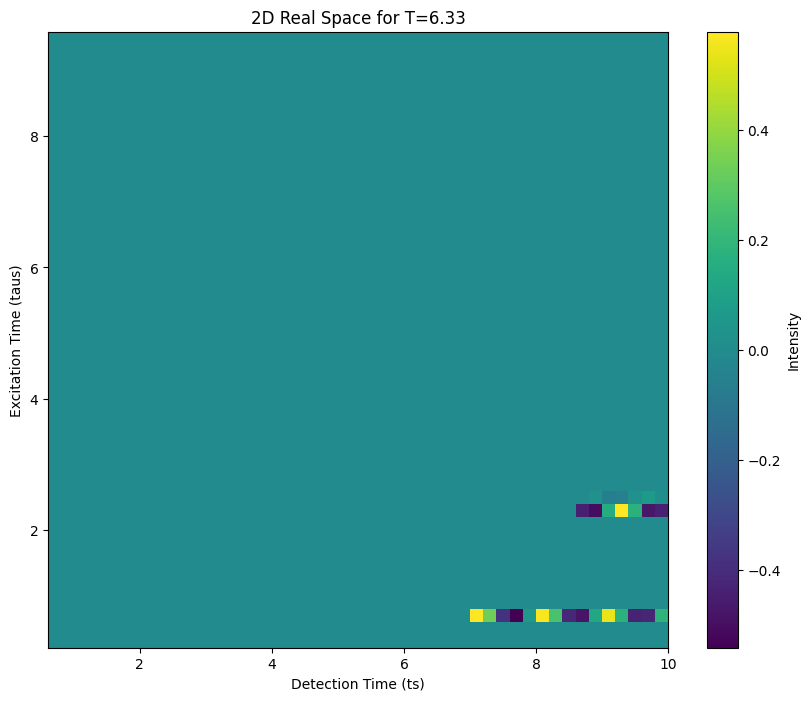

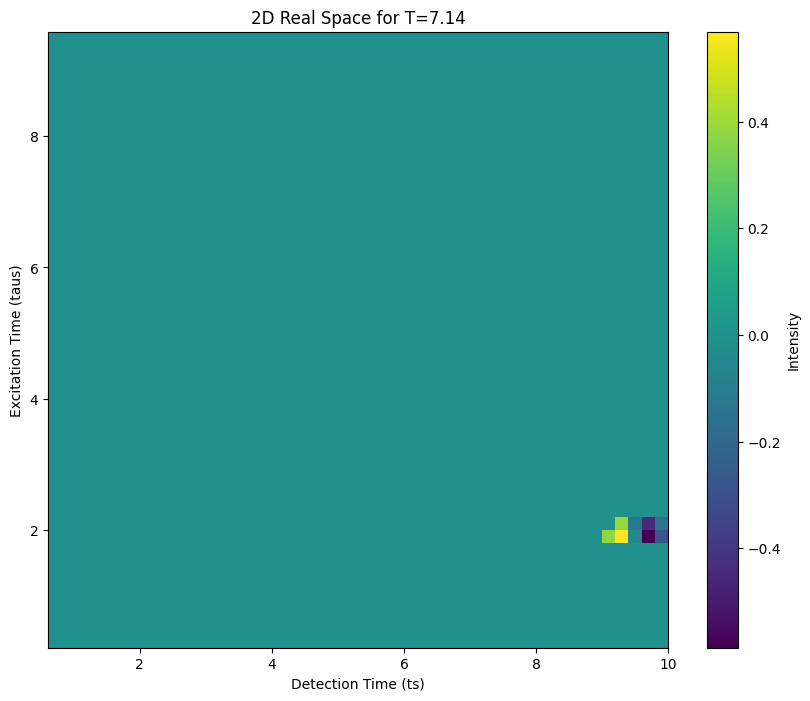

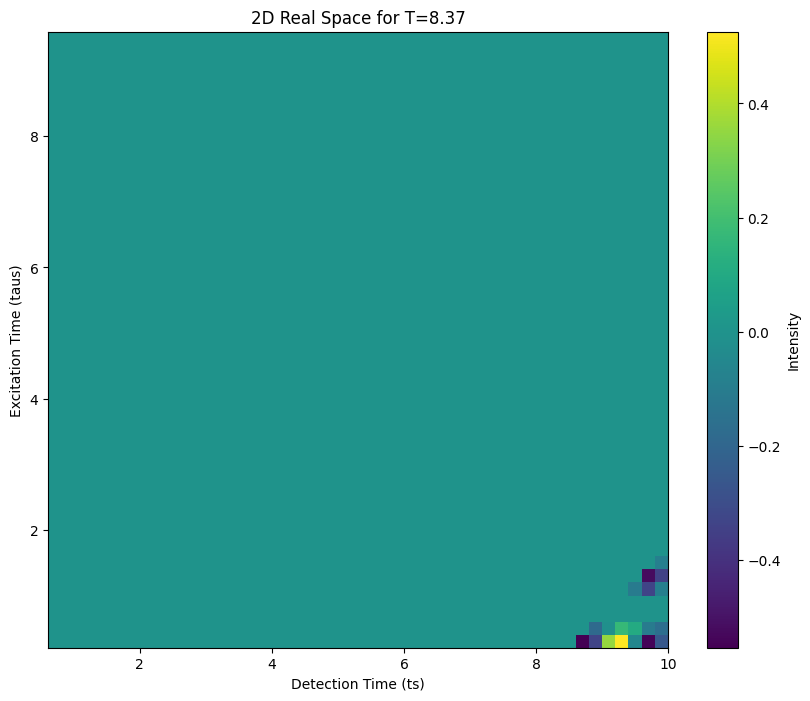

In [98]:
# Combine all unique ts and taus across all entries
global_ts = sorted(set(t for _, (_, ts, _) in two_d_array_dict.items() for t in ts))
global_taus = sorted(set(tau for _, (_, _, taus) in two_d_array_dict.items() for tau in taus))
# print(global_taus, global_ts)

# Create the global meshgrid
X_global, Y_global = np.meshgrid(global_ts, global_taus)

# Fill the global 2D array with available data
for idx, (T, (twoD_times, ts, taus)) in enumerate(two_d_array_dict.items()):
    # Only plot every 10th entry
    if idx % 10 != 0:
        continue

    # Initialize a global data array with zeros
    data = np.full(X_global.shape, 0.0)

    # Map local indices (ts to global_ts and taus to global_taus) using np.isclose
    ts_indices = [i for t in ts for i, global_t in enumerate(global_ts) if np.isclose(global_t, t)]
    taus_indices = [i for tau in taus for i, global_tau in enumerate(global_taus) if np.isclose(global_tau, tau)]

    # Validate that mapping worked correctly
    if len(ts_indices) != len(ts) or len(taus_indices) != len(taus):
        print(f"Warning: Not all ts or taus mapped correctly for T={T}.")

    # Fill the global 2D array with the local data
    for local_tau_idx, global_tau_idx in enumerate(taus_indices):
        for local_t_idx, global_t_idx in enumerate(ts_indices):
            if 0 <= global_tau_idx < data.shape[0] and 0 <= global_t_idx < data.shape[1]:
                data[global_tau_idx, global_t_idx] = twoD_times[local_t_idx, local_tau_idx]
            else:
                print(f"Skipping out-of-bounds index: ({global_tau_idx}, {global_t_idx}) for T={T}.")

    # Plot the real-space data using imshow
    plt.figure(figsize=(10, 8))
    extent = [global_ts[0], global_ts[-1], global_taus[0], global_taus[-1]]  # Set extent for proper axis scaling
    plt.imshow(data, extent=extent, origin='lower', aspect='auto', cmap='viridis')
    plt.colorbar(label="Intensity")
    plt.title(f"2D Real Space for T={T:.2f}")
    plt.xlabel("Detection Time (ts)")
    plt.ylabel("Excitation Time (taus)")
    plt.show()

<>:36: SyntaxWarning: invalid escape sequence '\o'
<>:37: SyntaxWarning: invalid escape sequence '\o'
<>:36: SyntaxWarning: invalid escape sequence '\o'
<>:37: SyntaxWarning: invalid escape sequence '\o'
/tmp/ipykernel_39076/3547991723.py:36: SyntaxWarning: invalid escape sequence '\o'
  plt.xlabel("$\omega_{det}$ (arb. units)")
/tmp/ipykernel_39076/3547991723.py:37: SyntaxWarning: invalid escape sequence '\o'
  plt.ylabel("$\omega_{exc}$ (arb. units)")


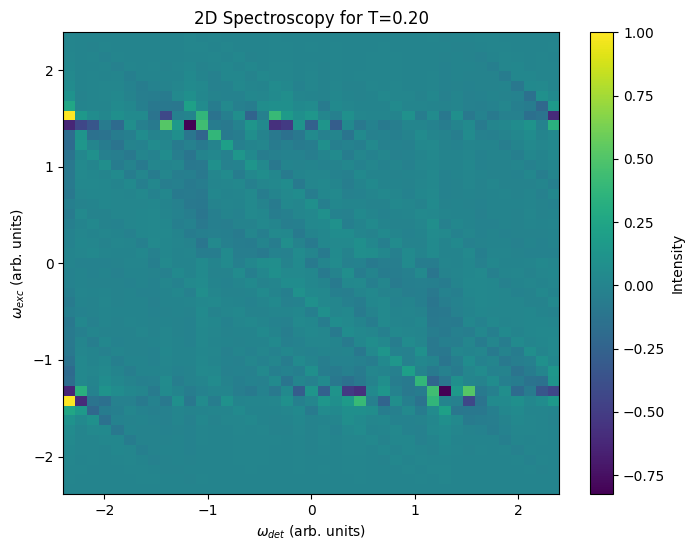

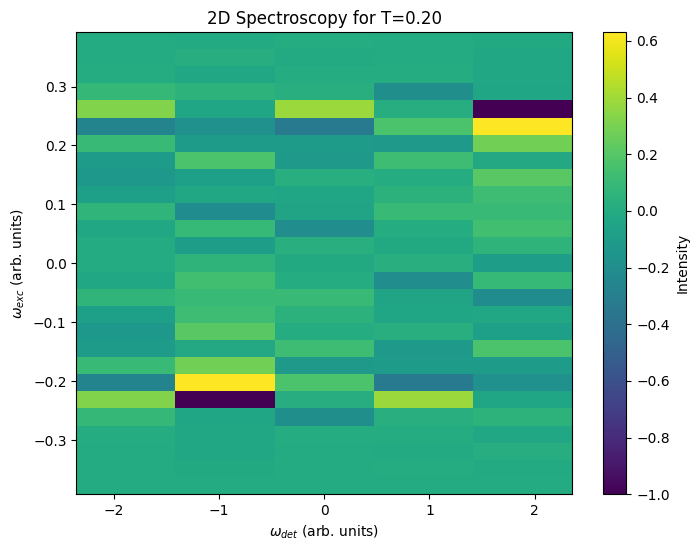

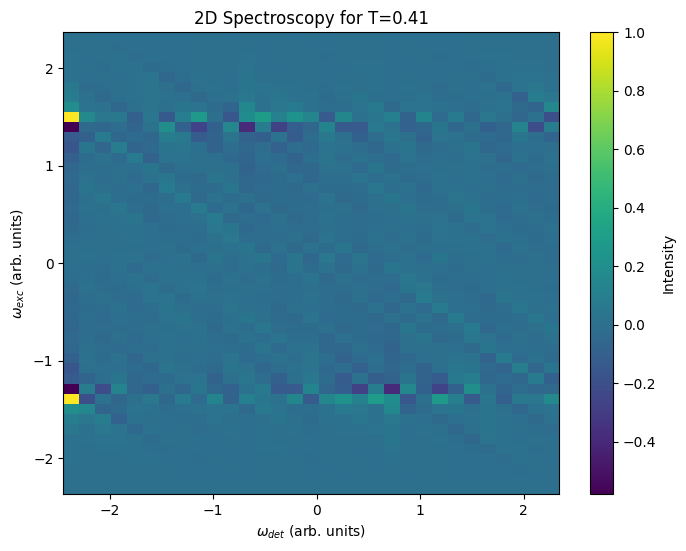

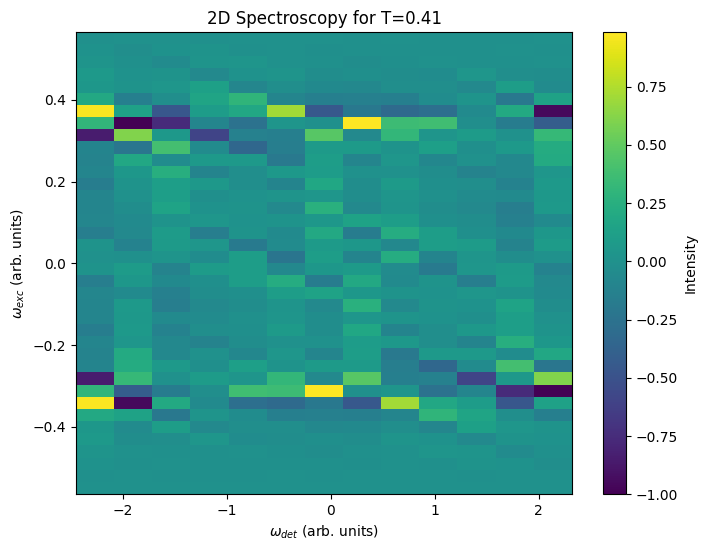

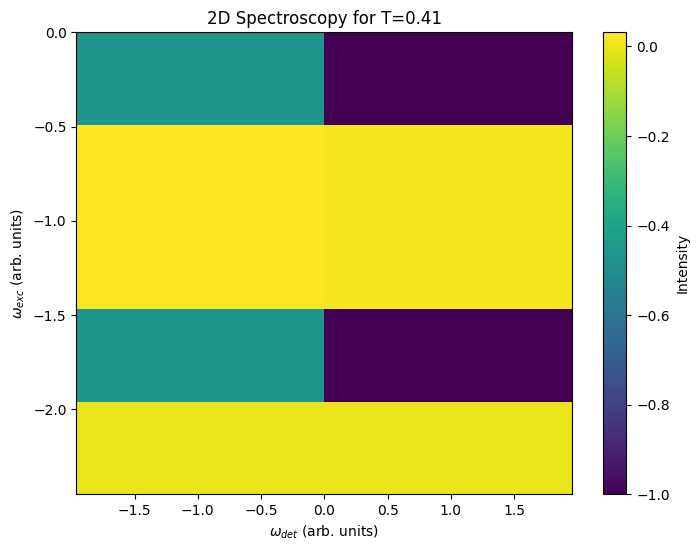

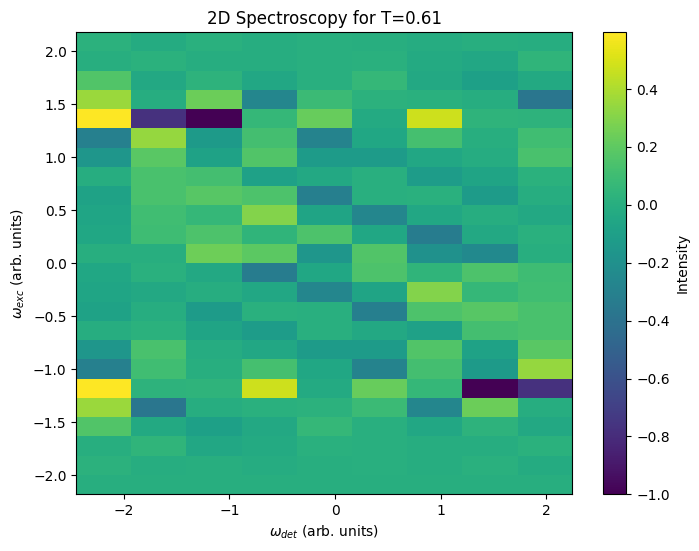

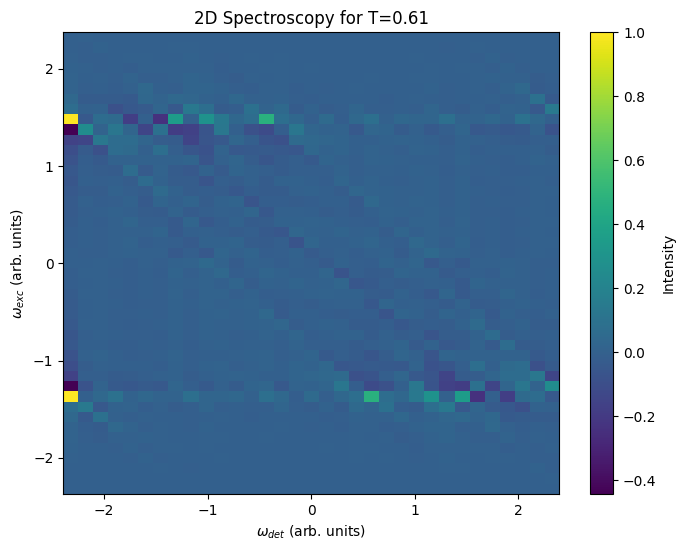

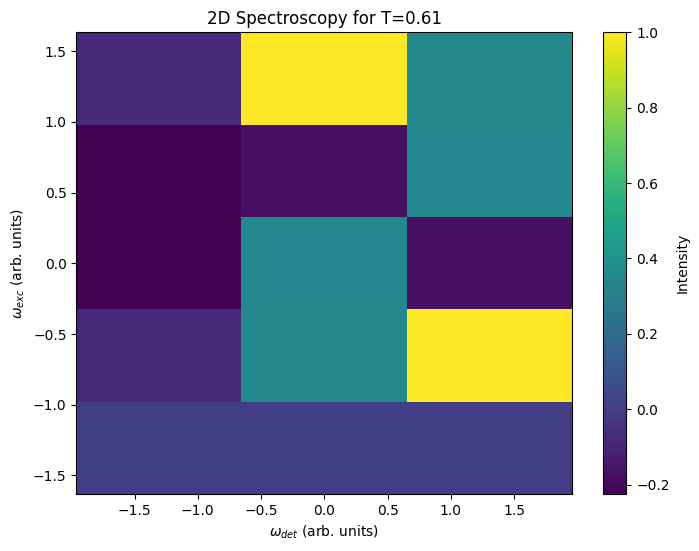

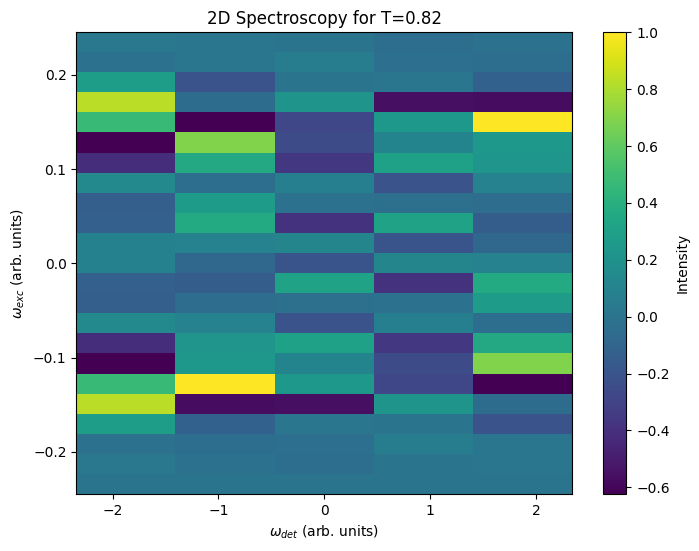

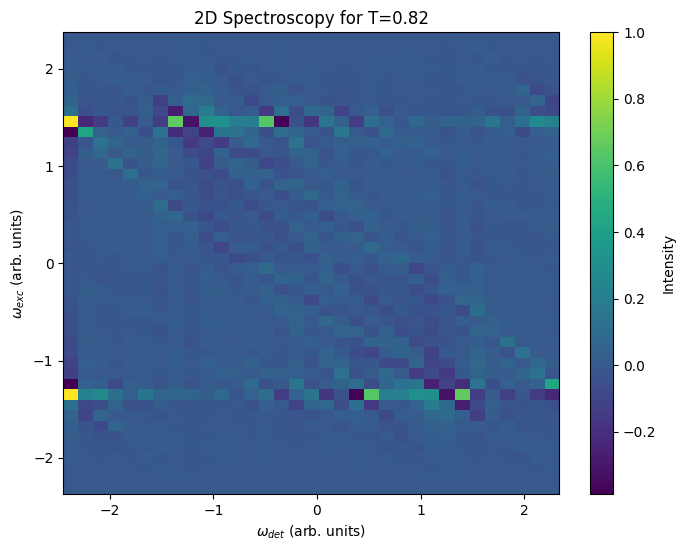

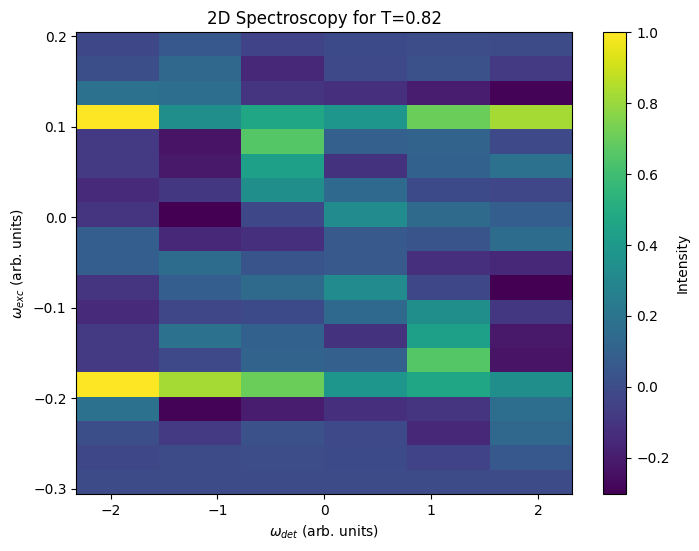

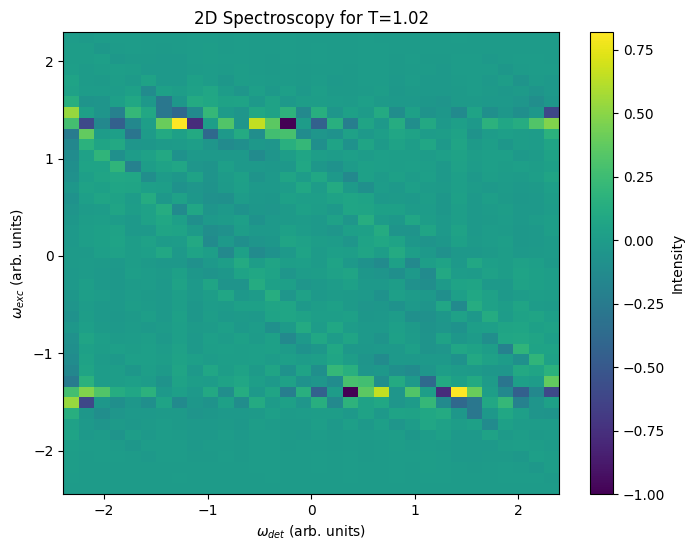

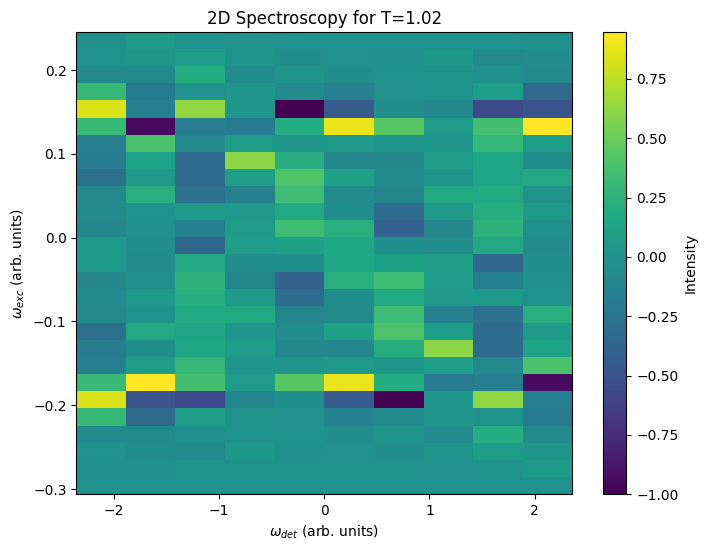

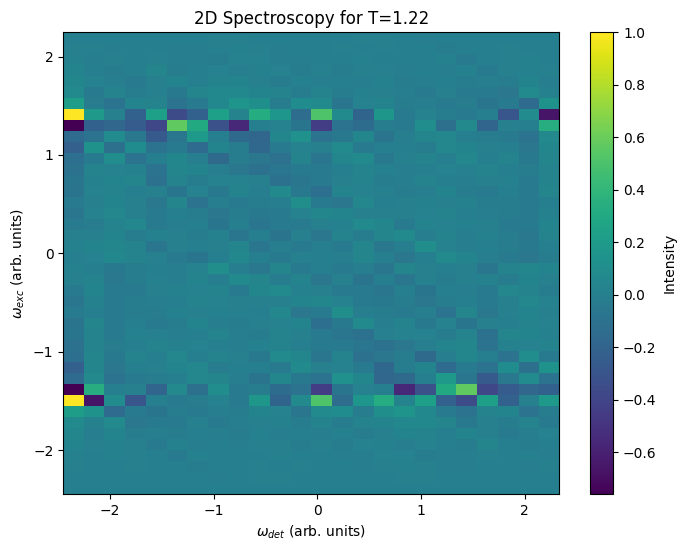

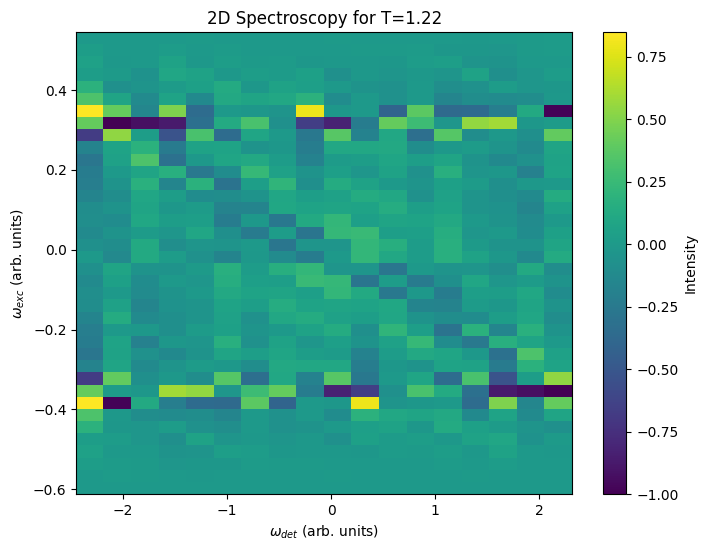

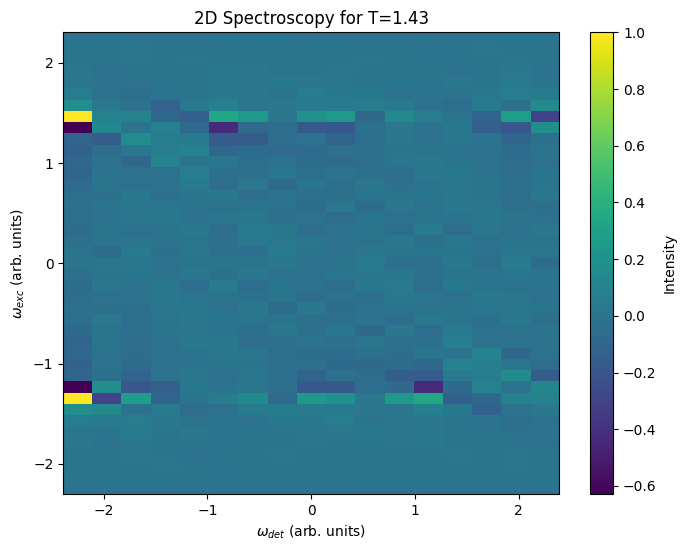

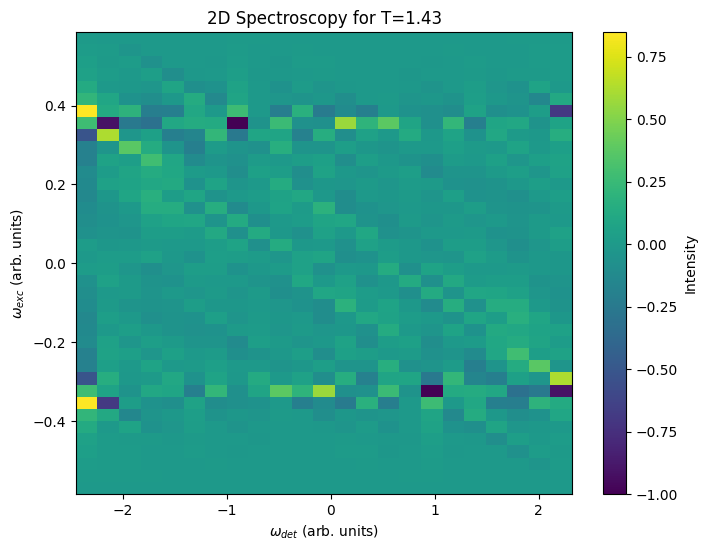

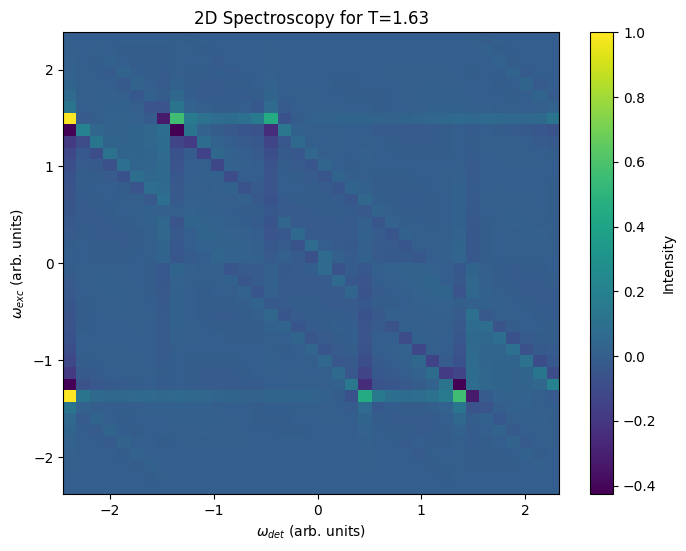

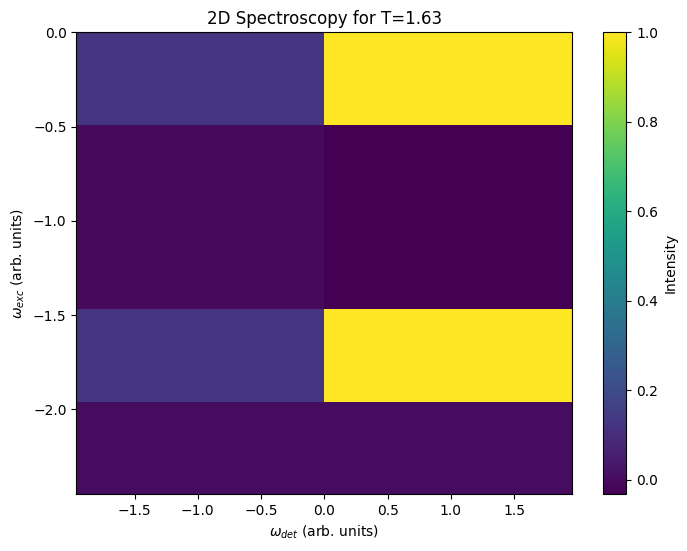

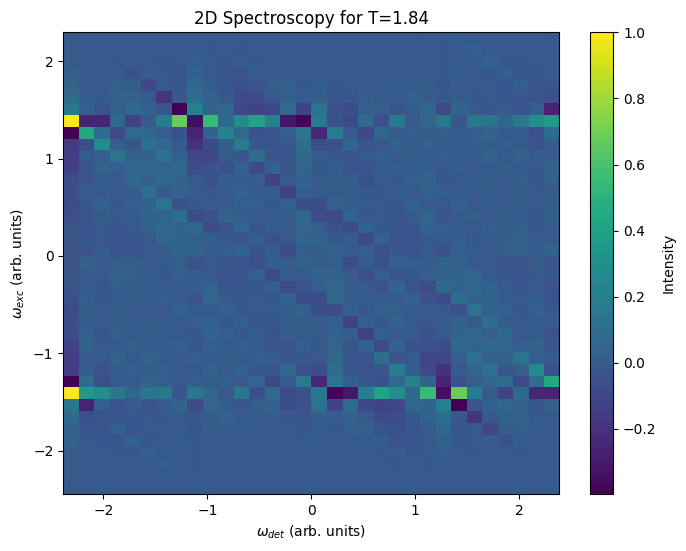

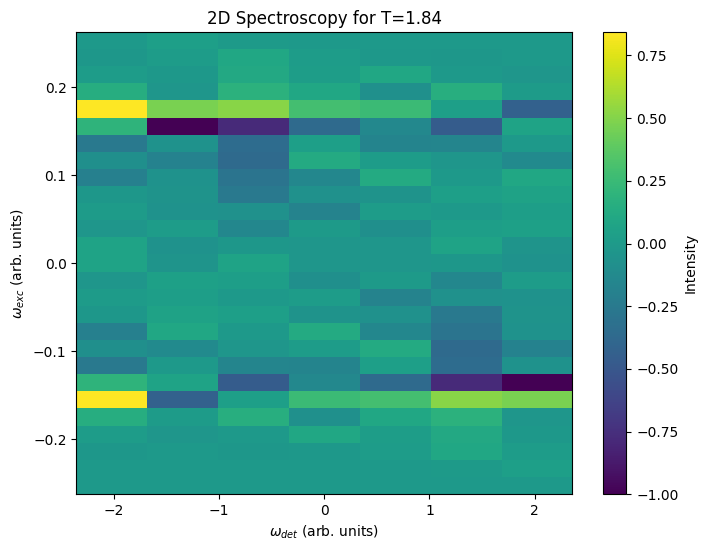

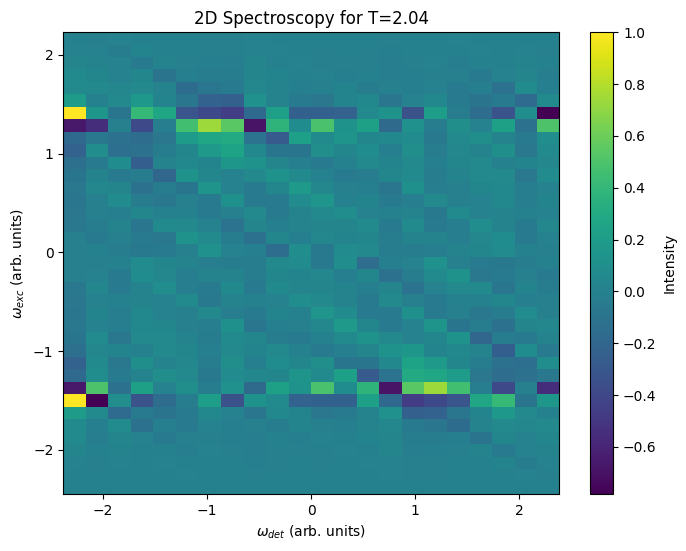

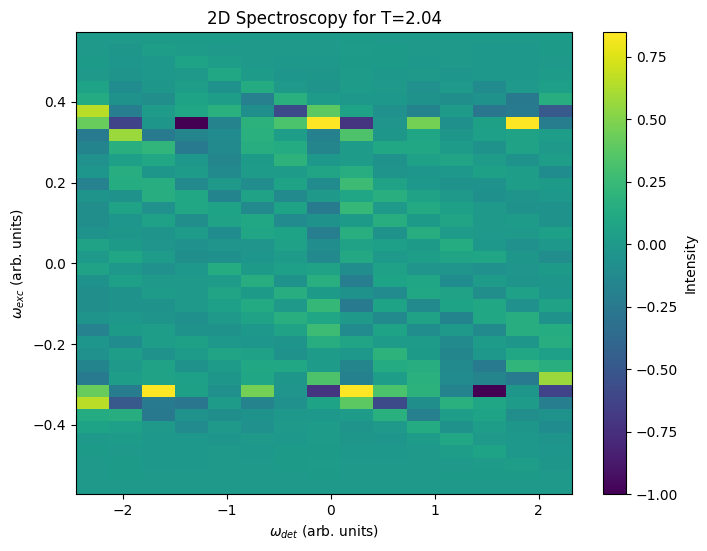

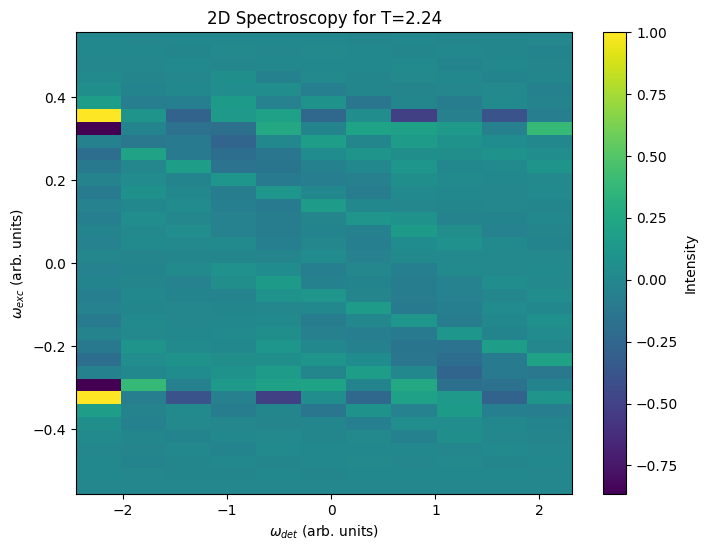

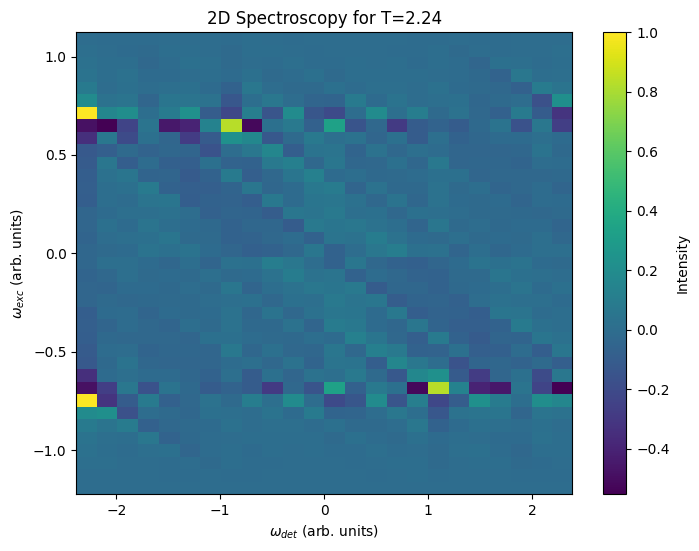

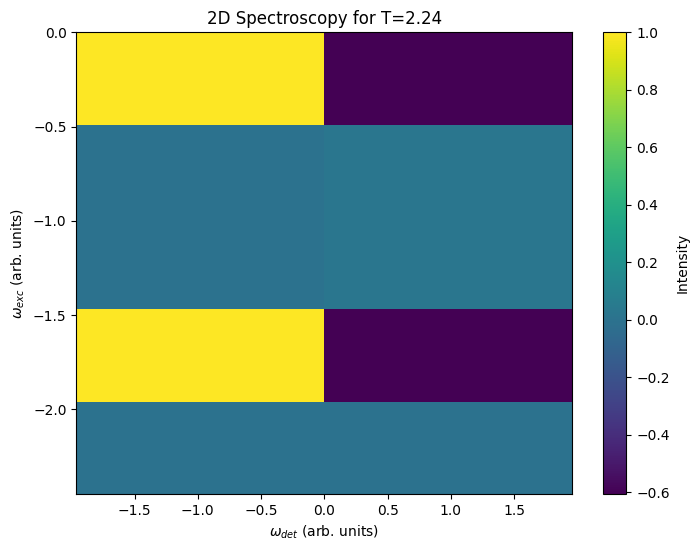

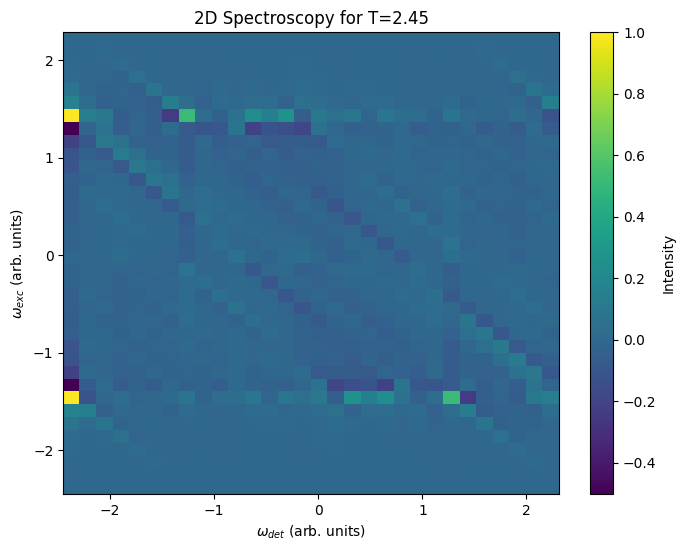

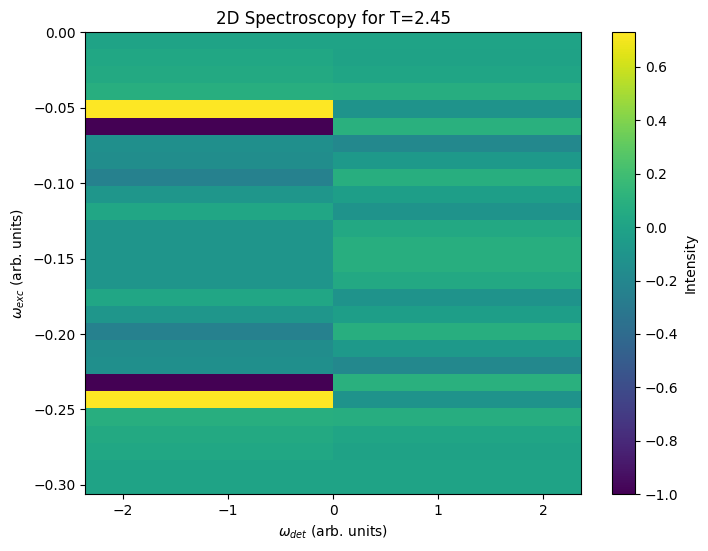

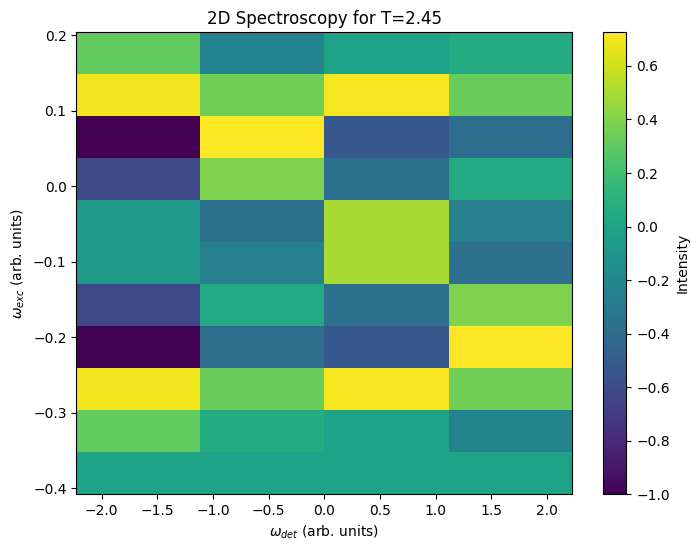

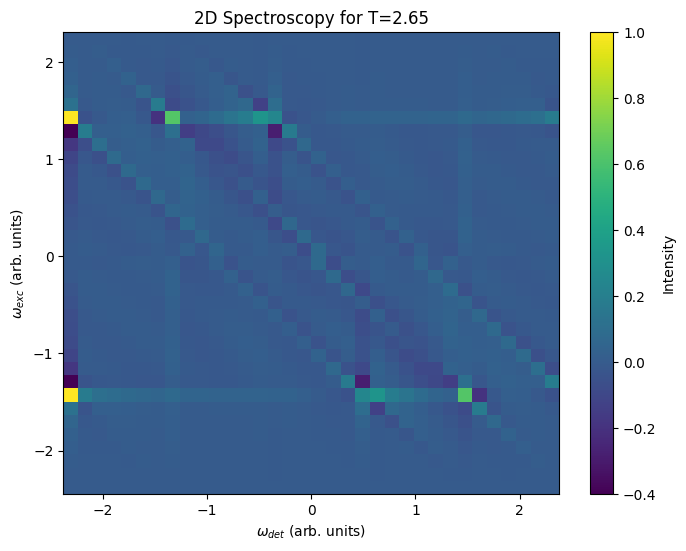

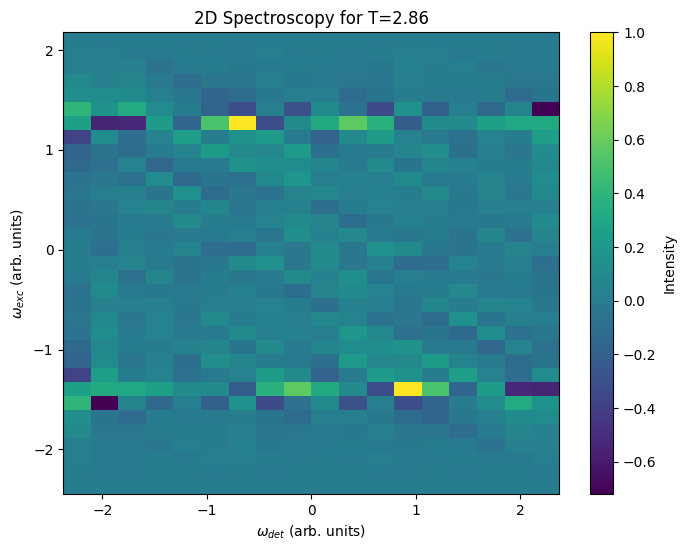

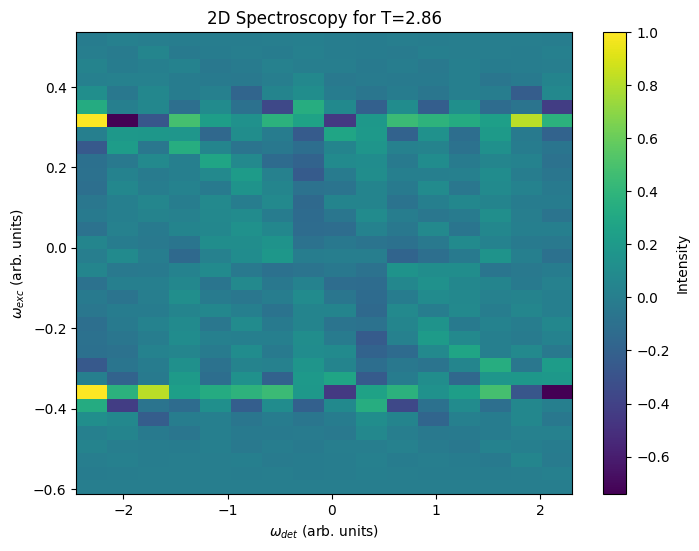

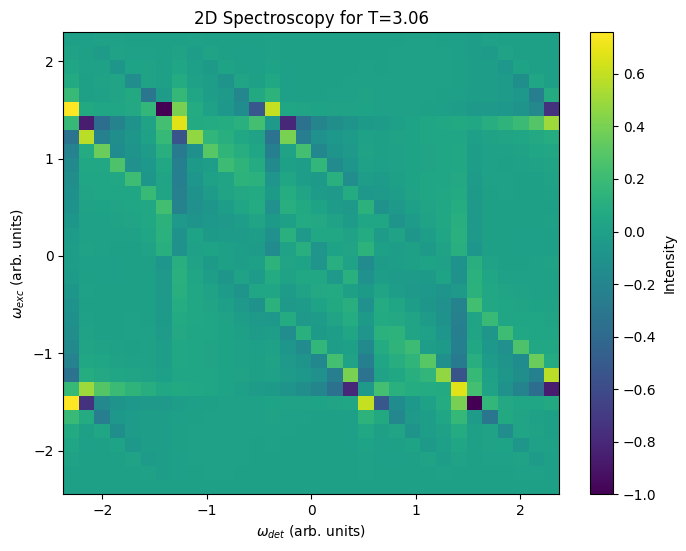

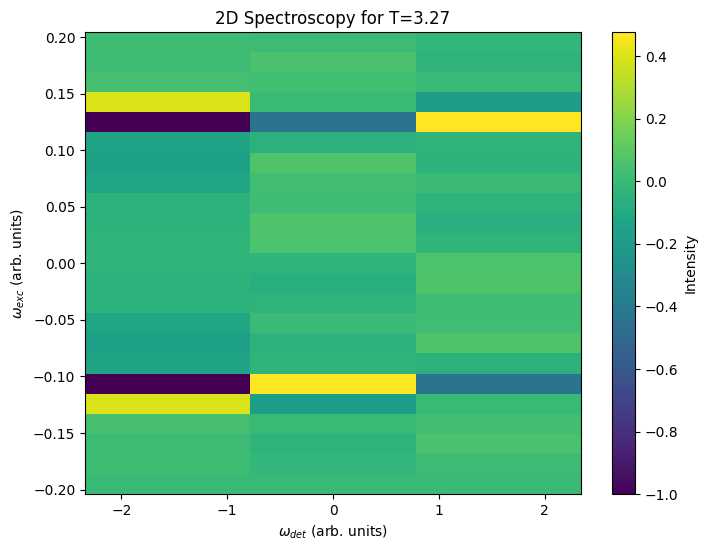

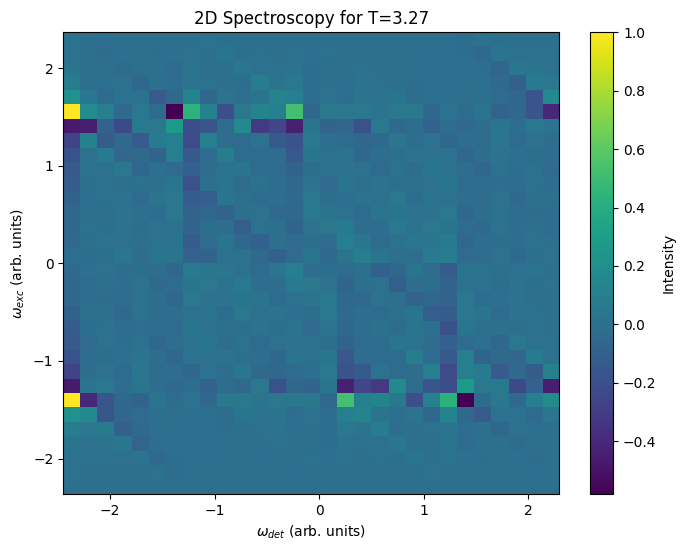

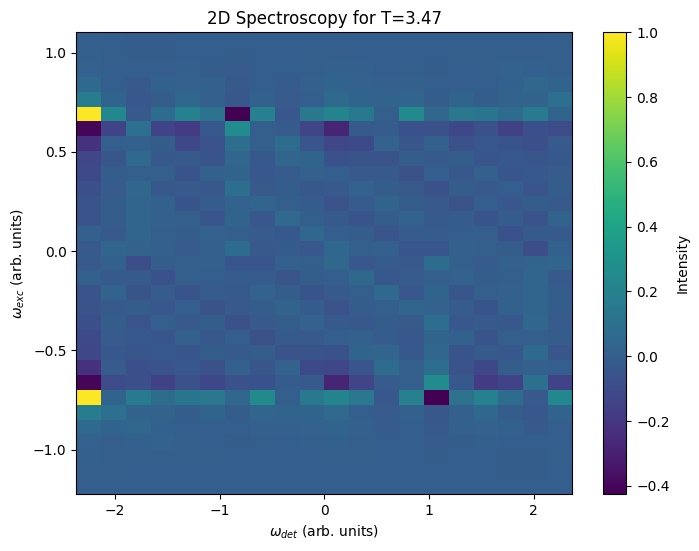

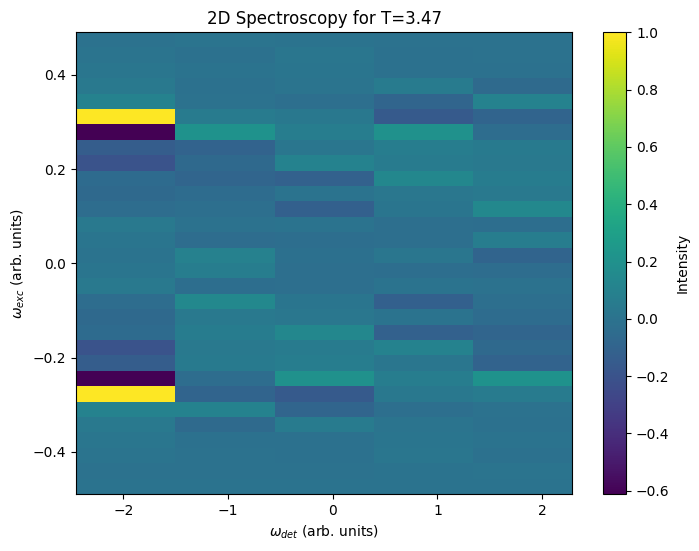

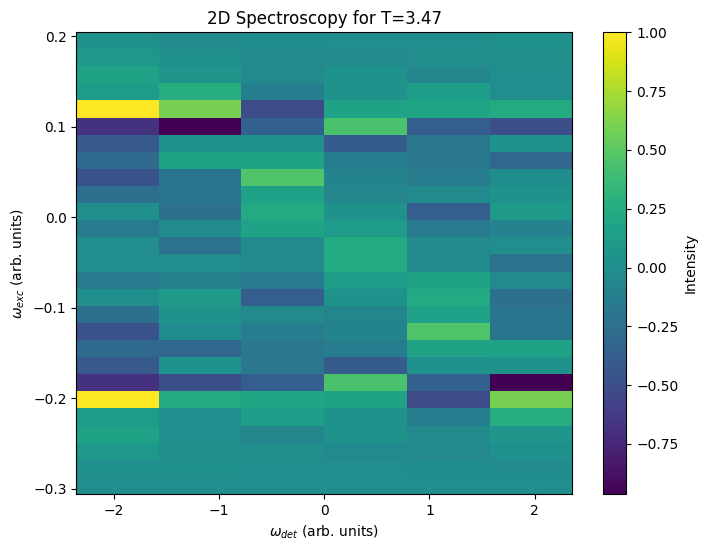

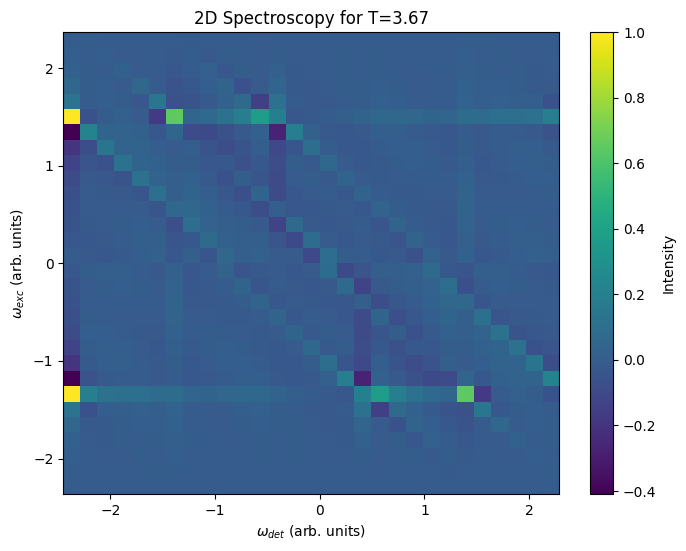

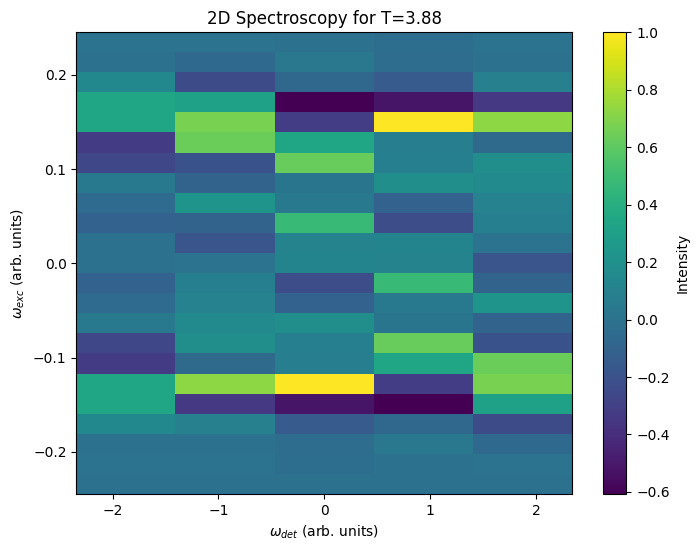

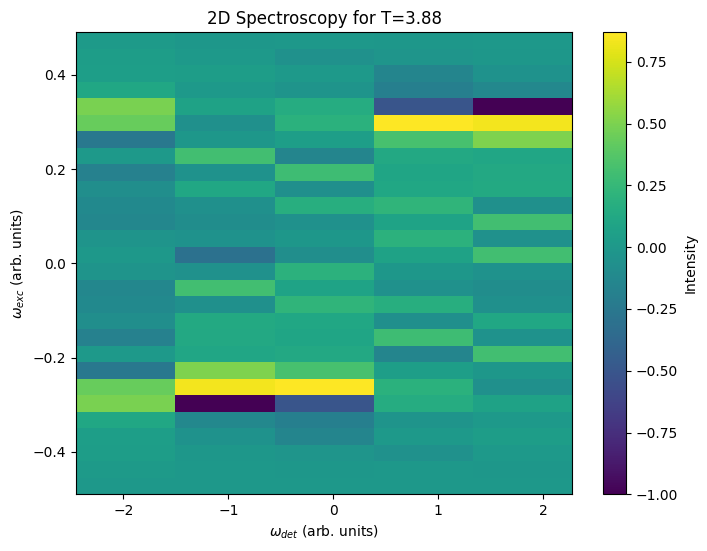

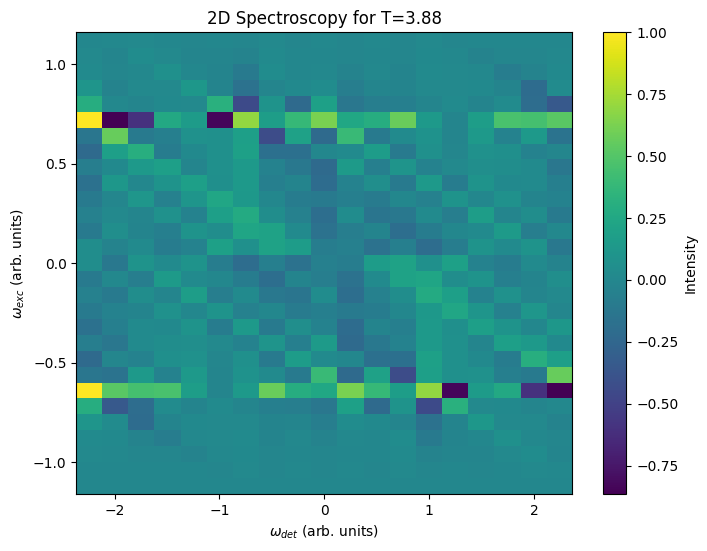

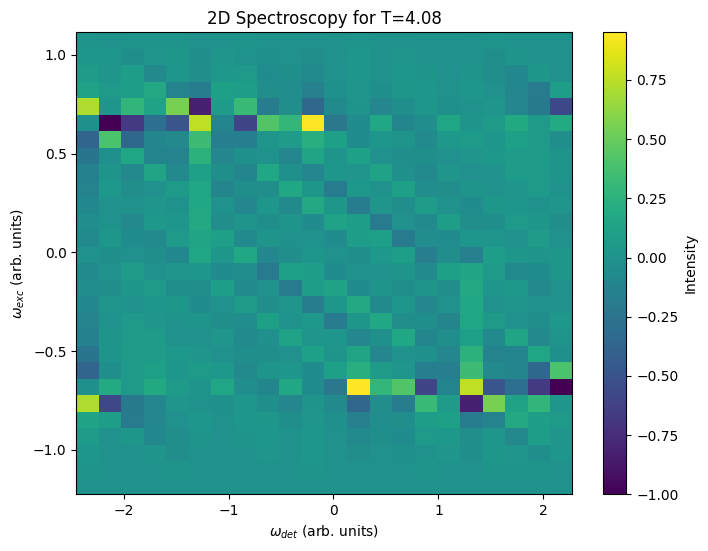

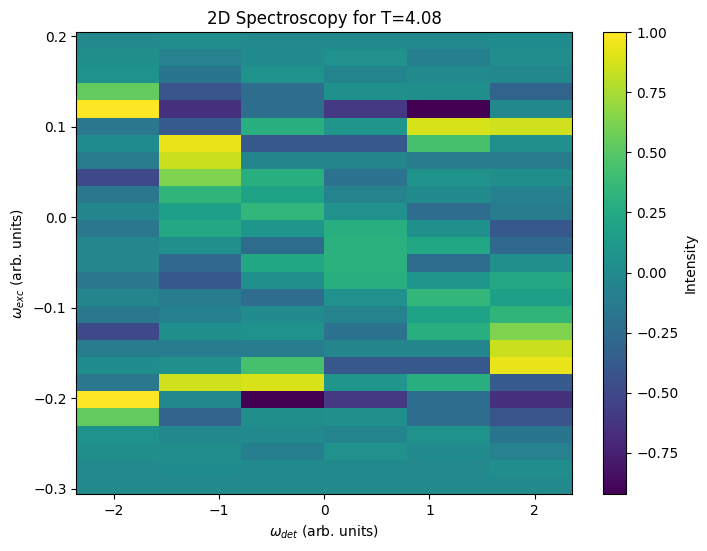

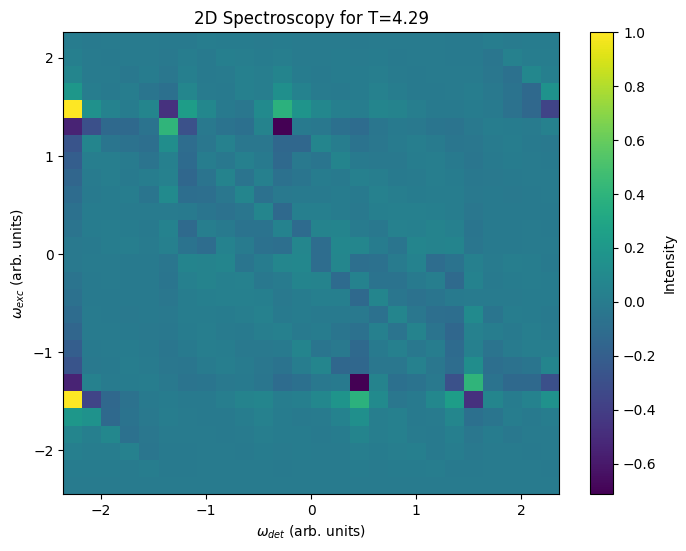

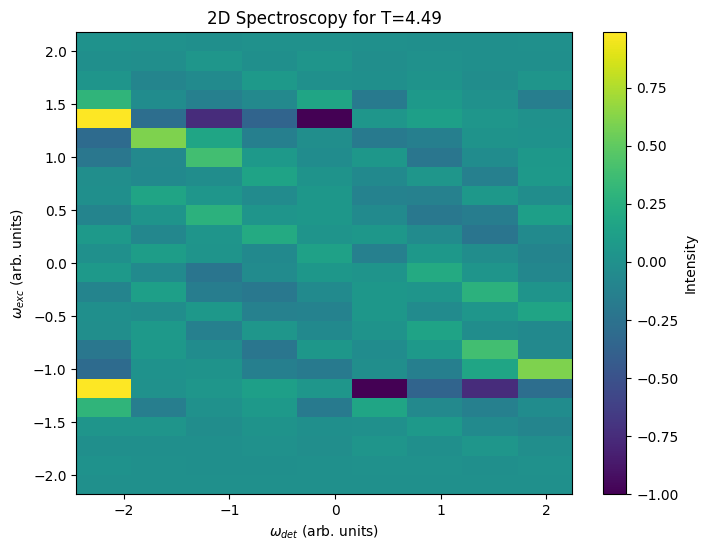

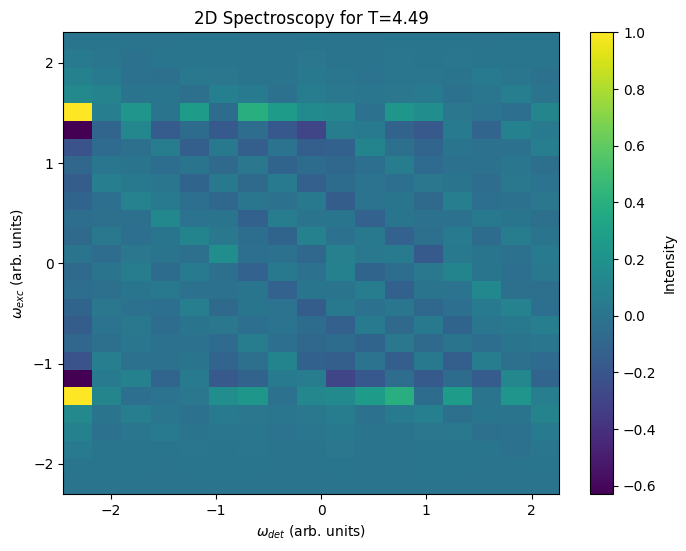

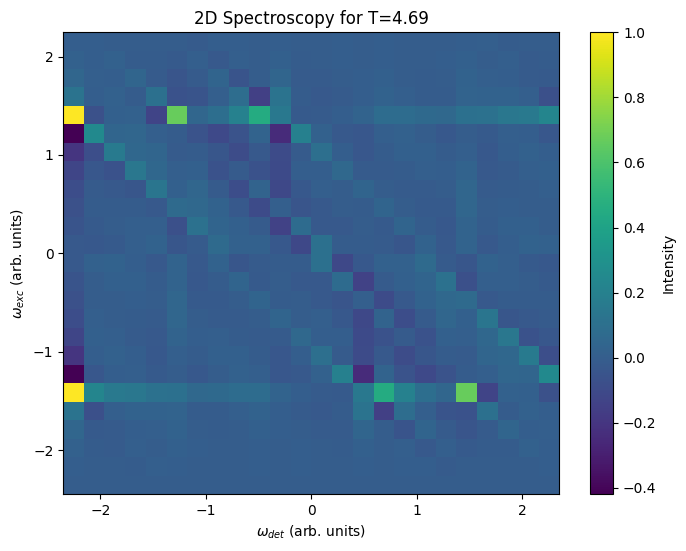

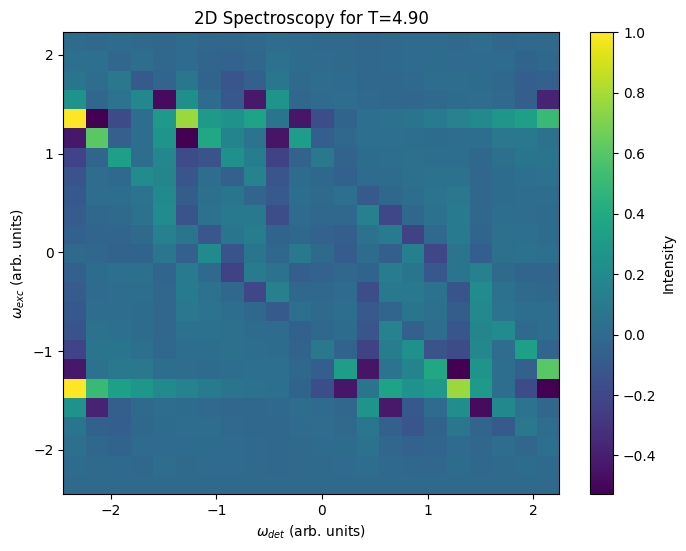

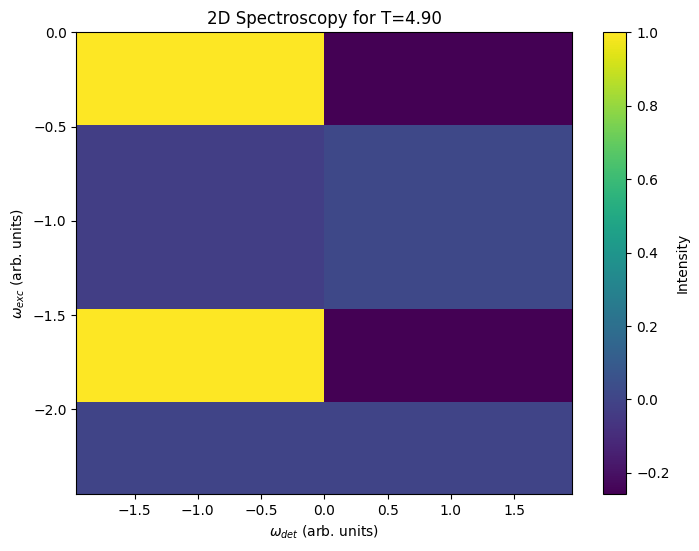

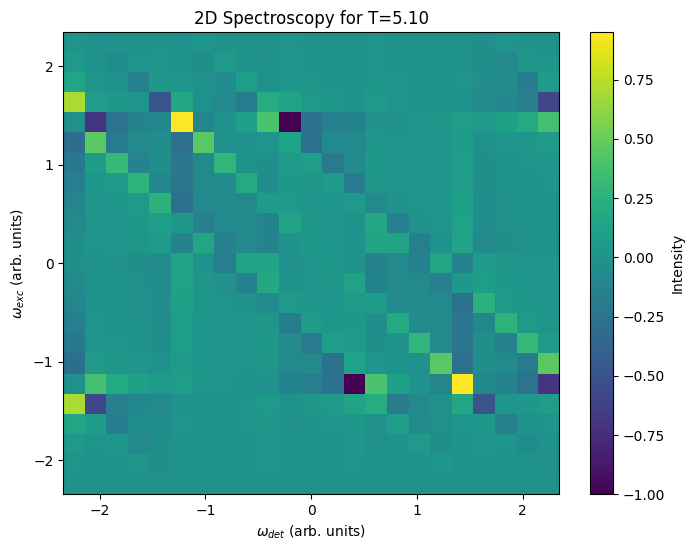

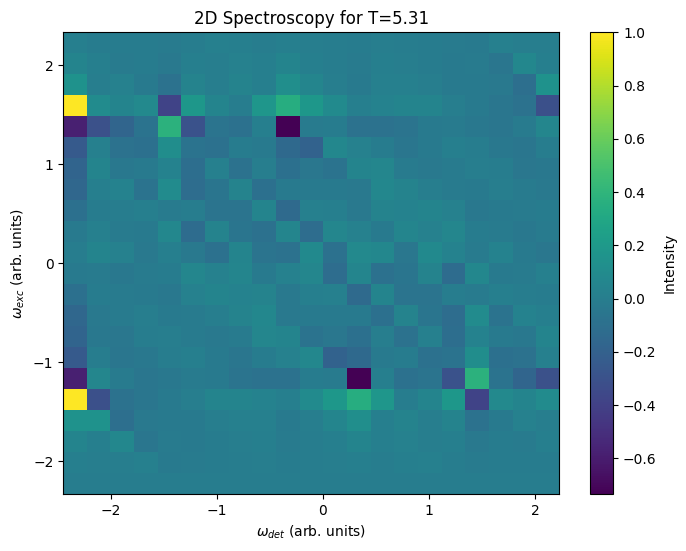

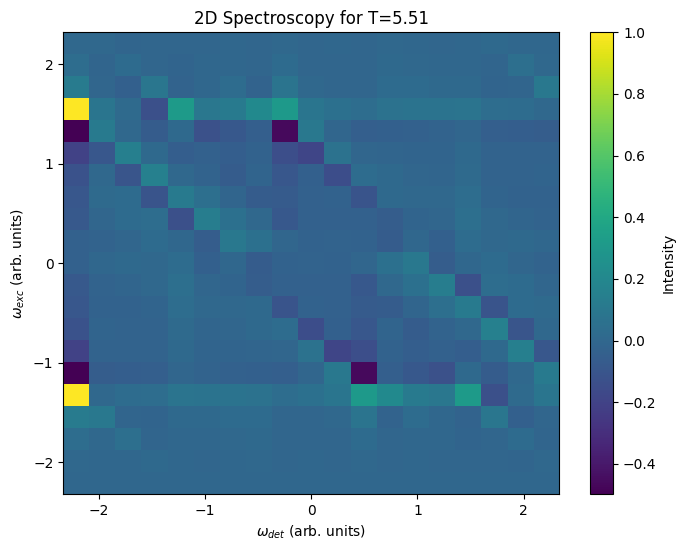

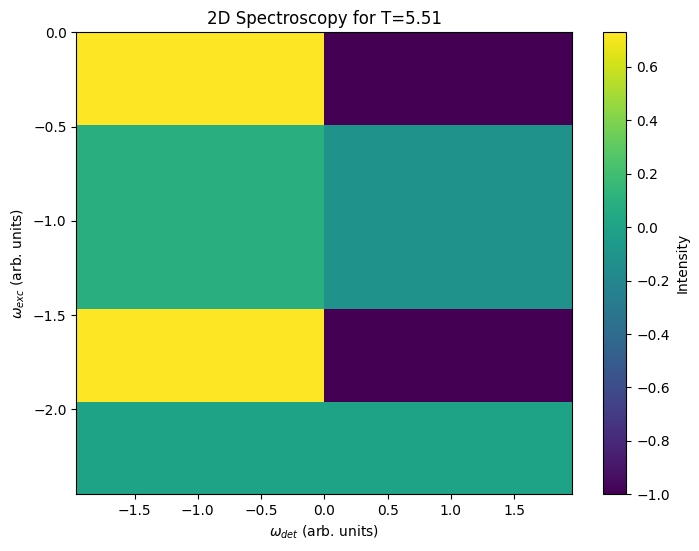

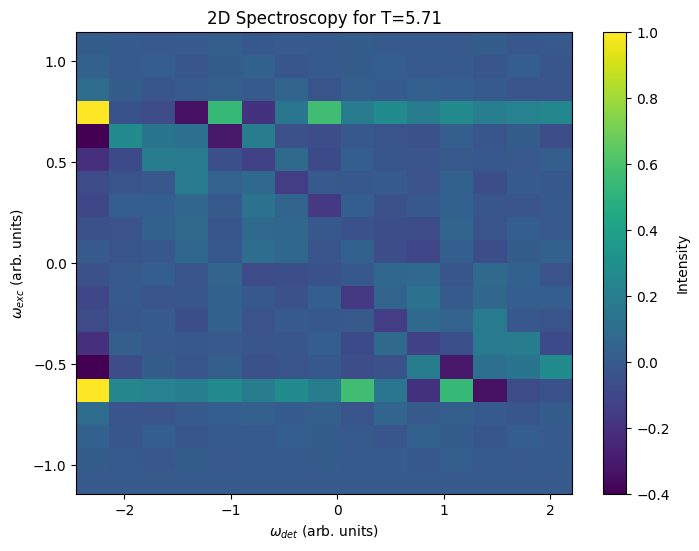

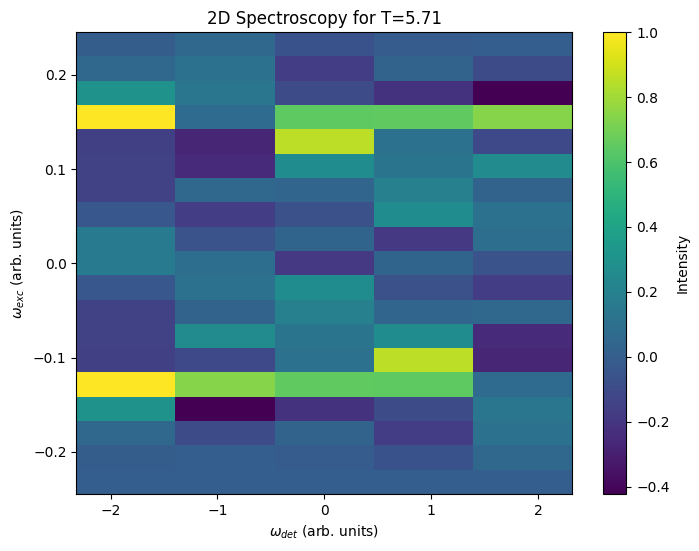

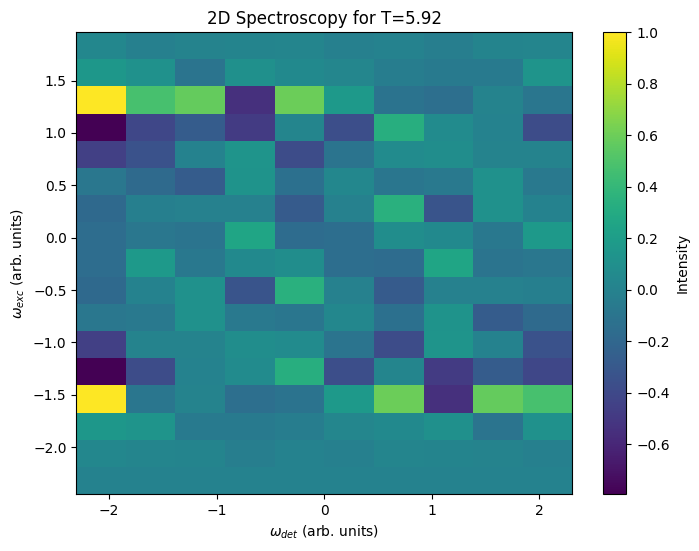

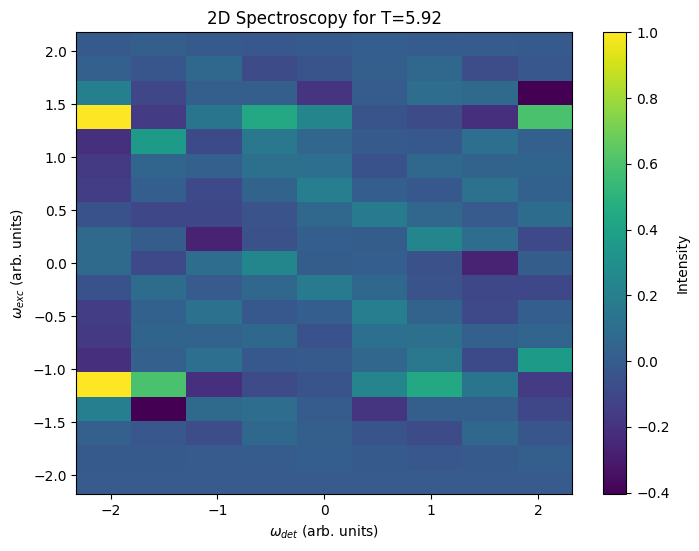

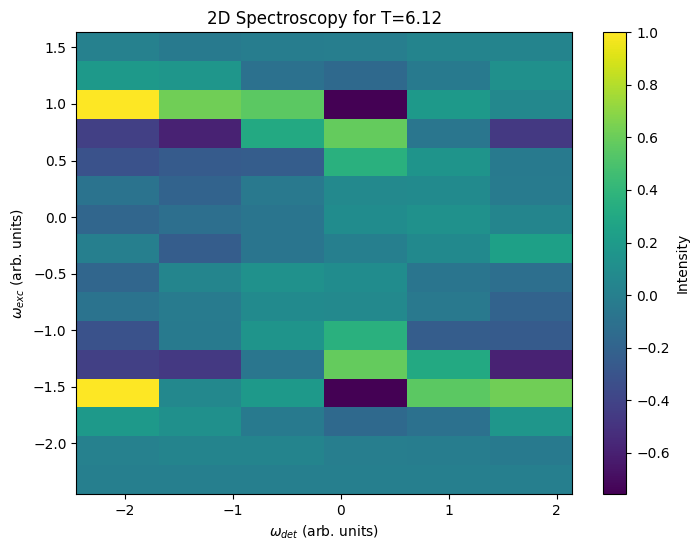

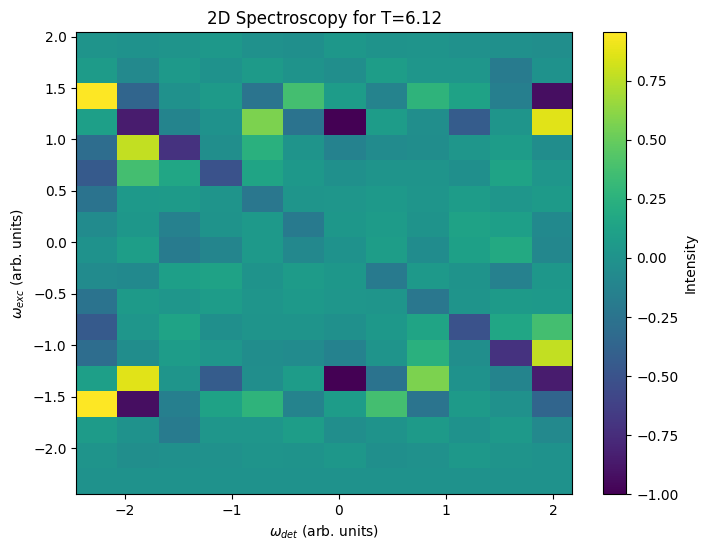

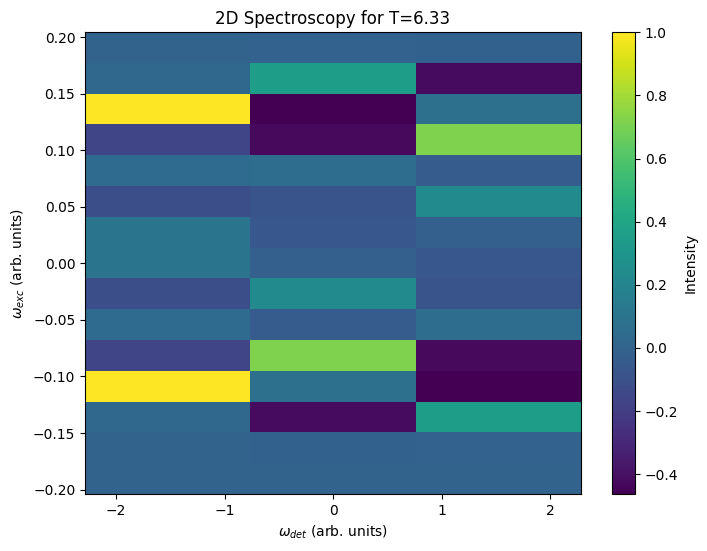

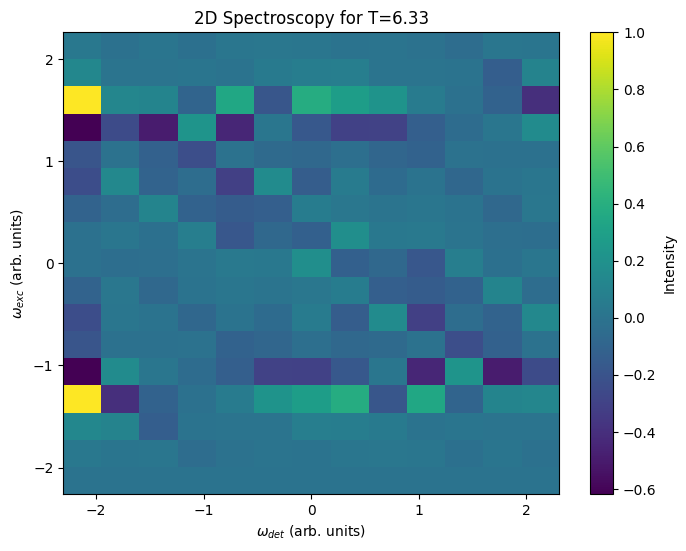

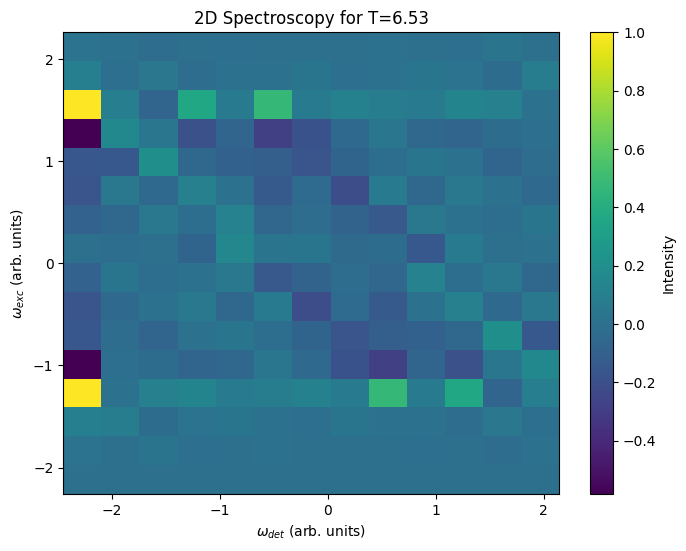

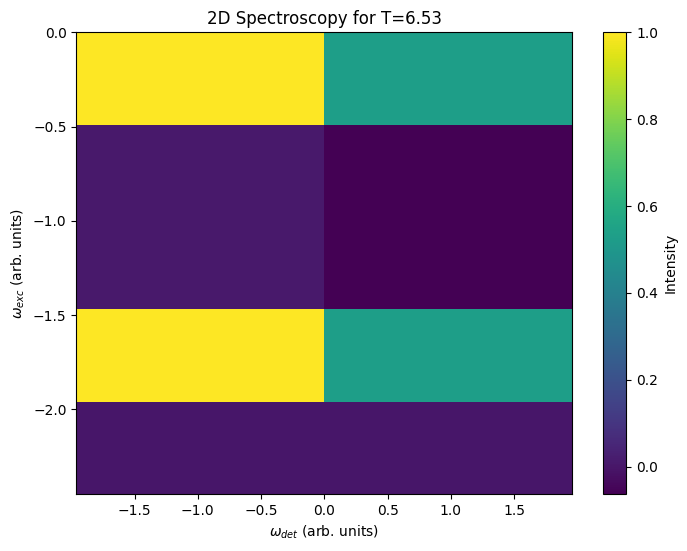

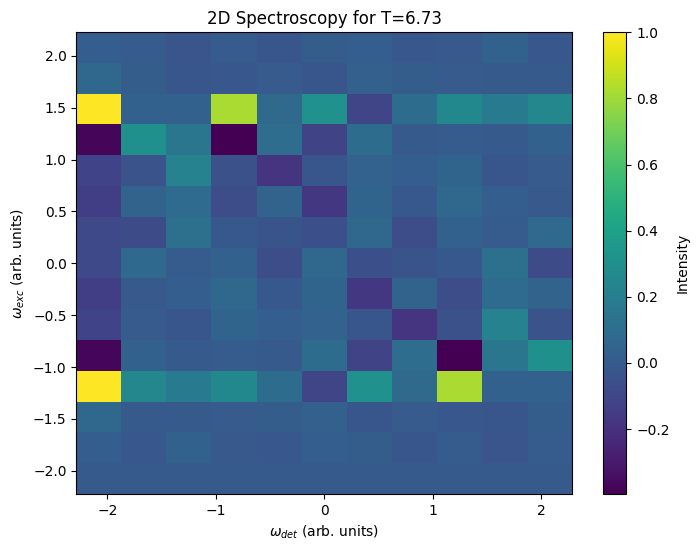

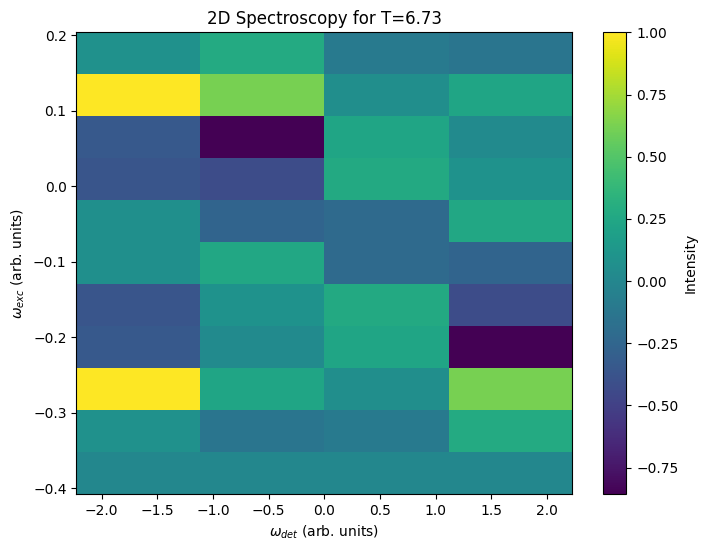

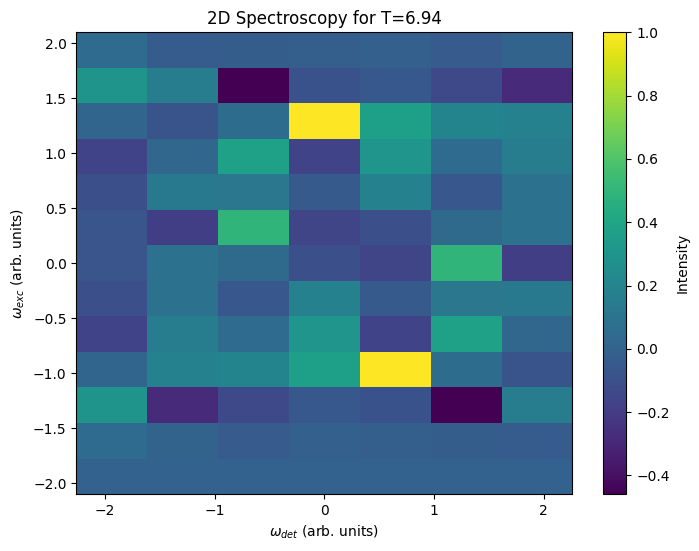

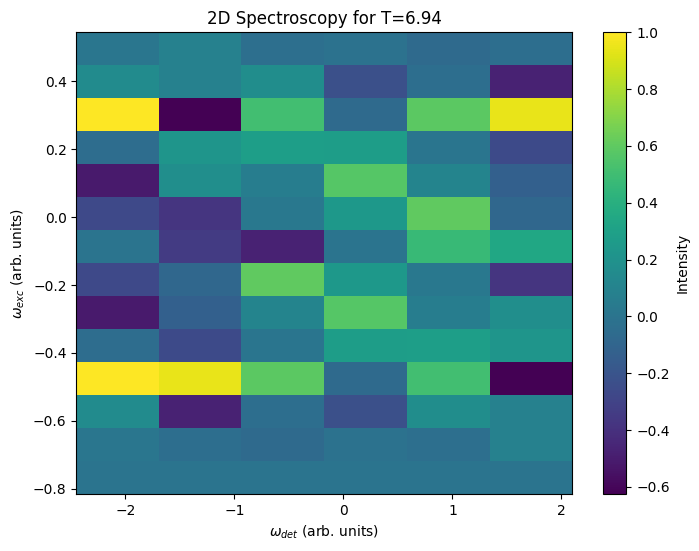

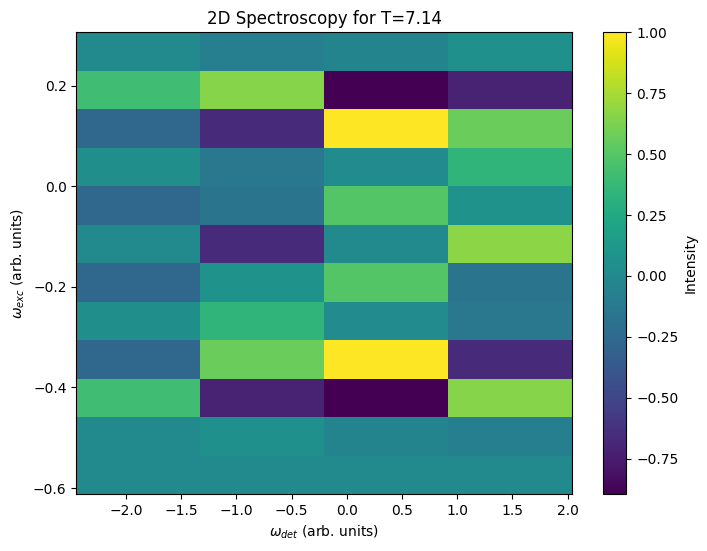

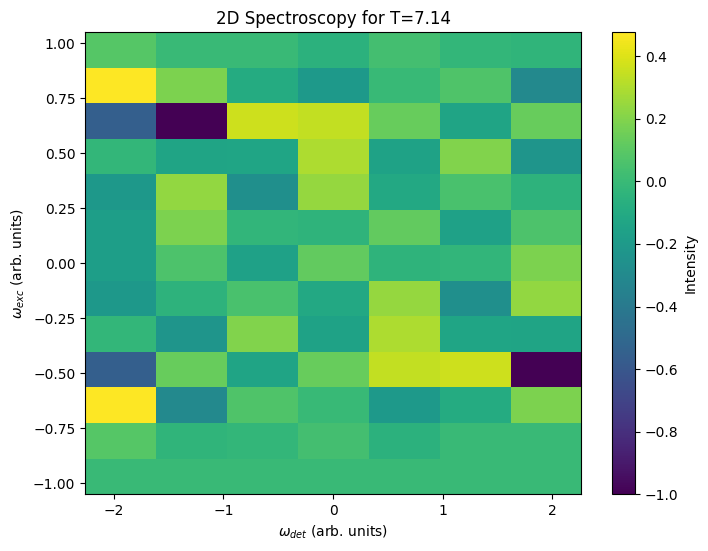

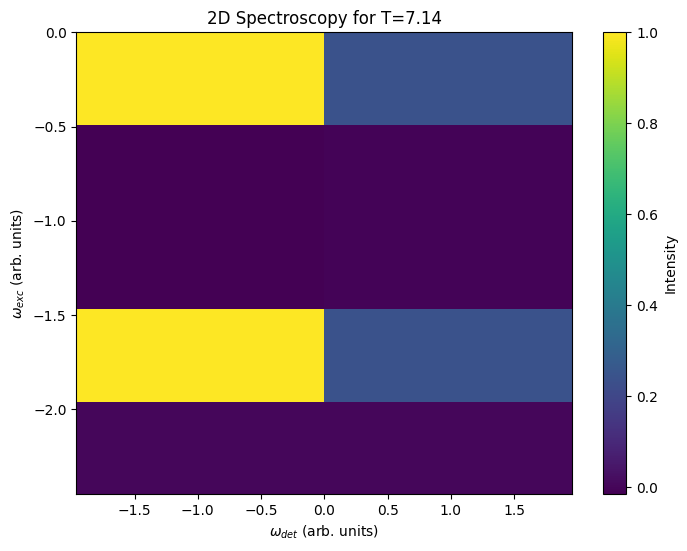

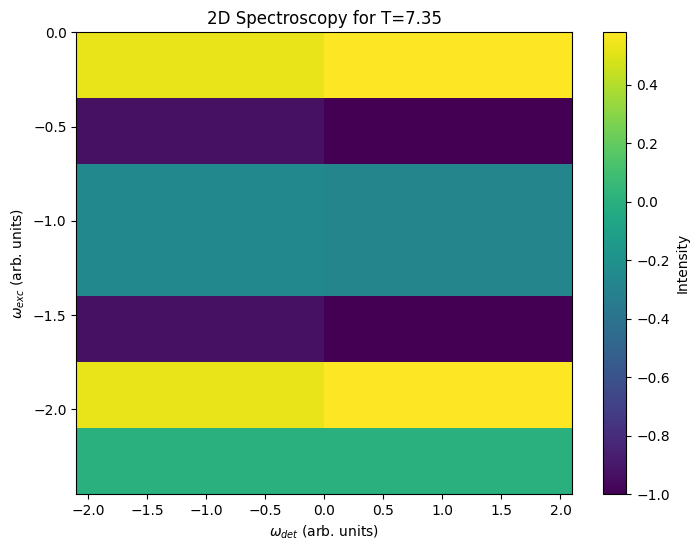

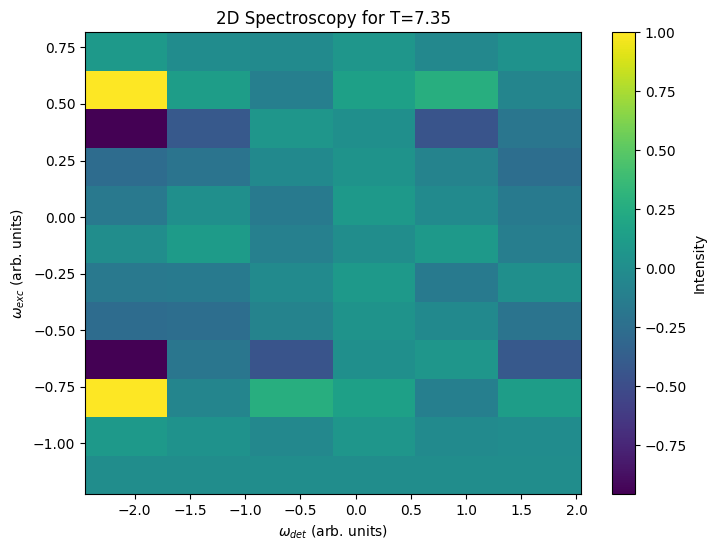

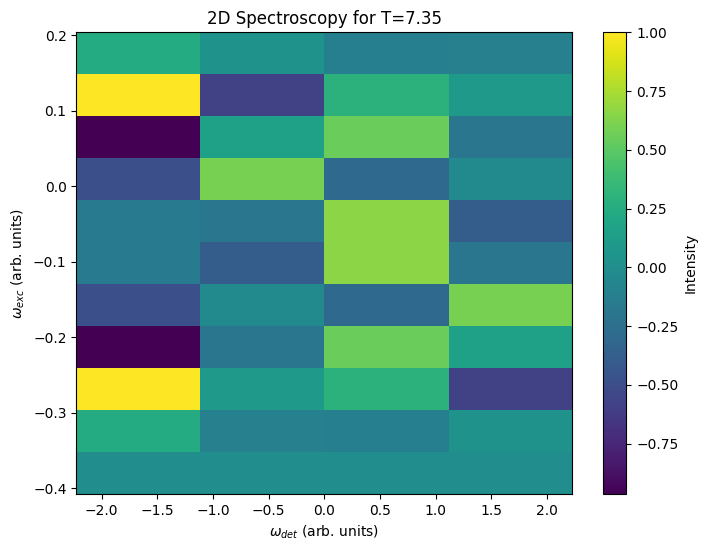

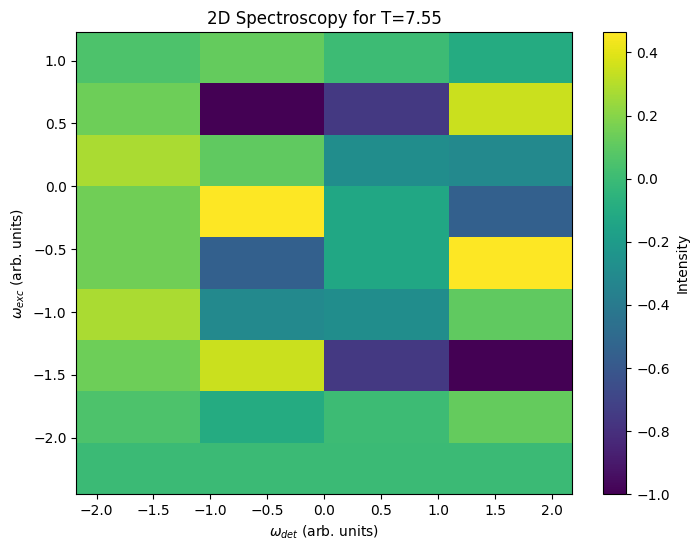

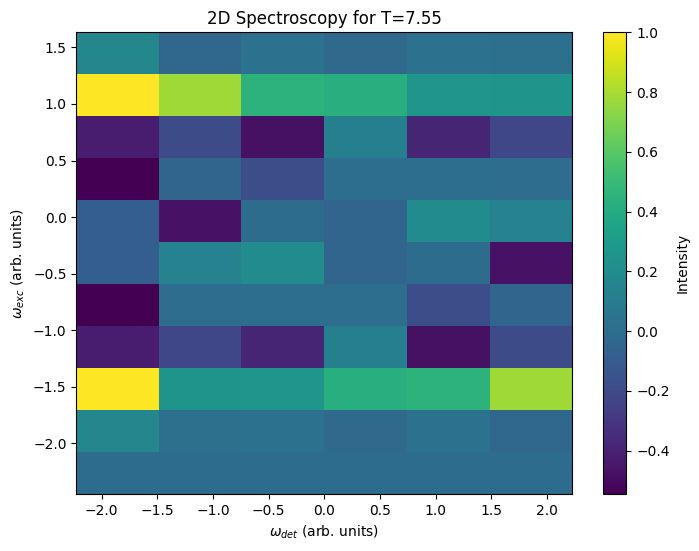

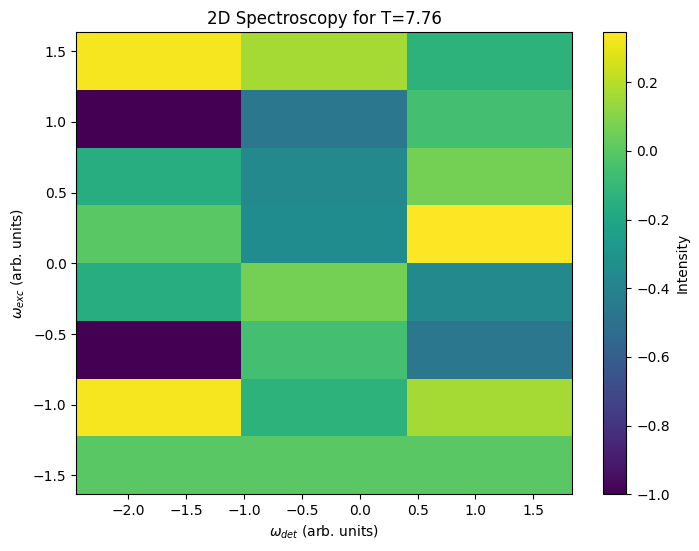

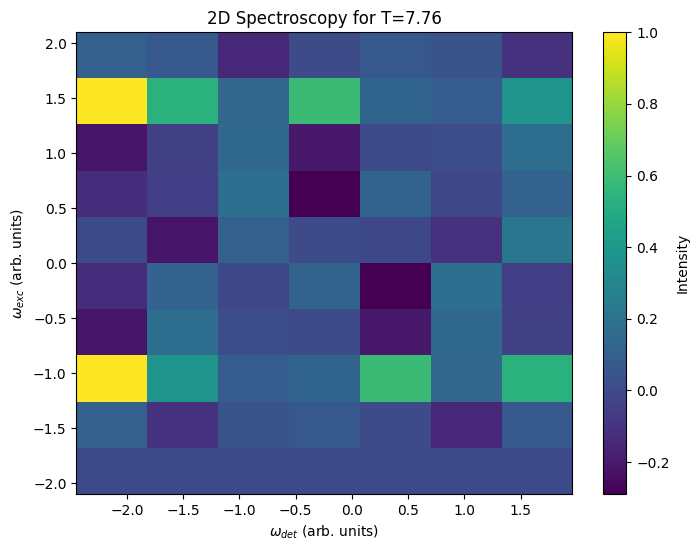

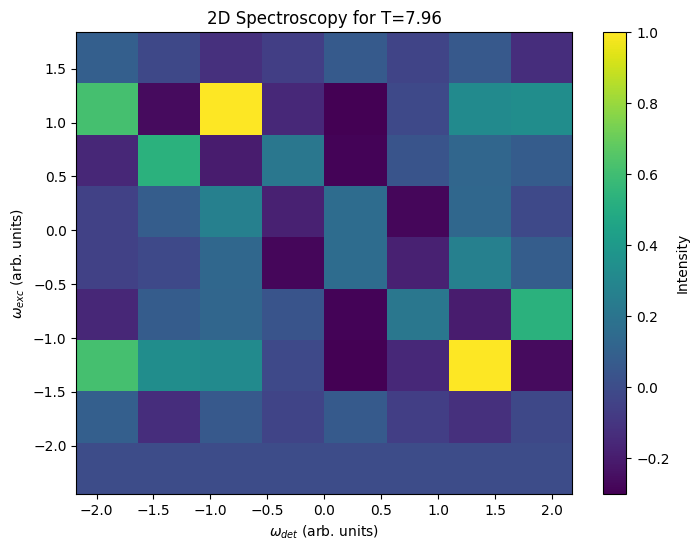

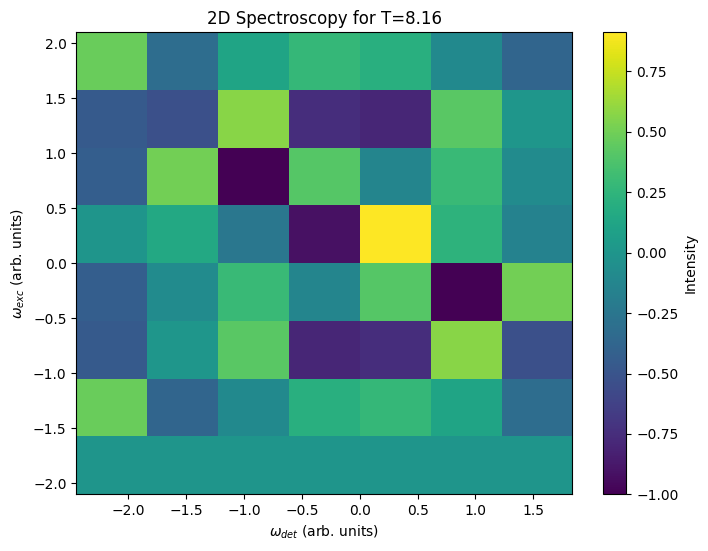

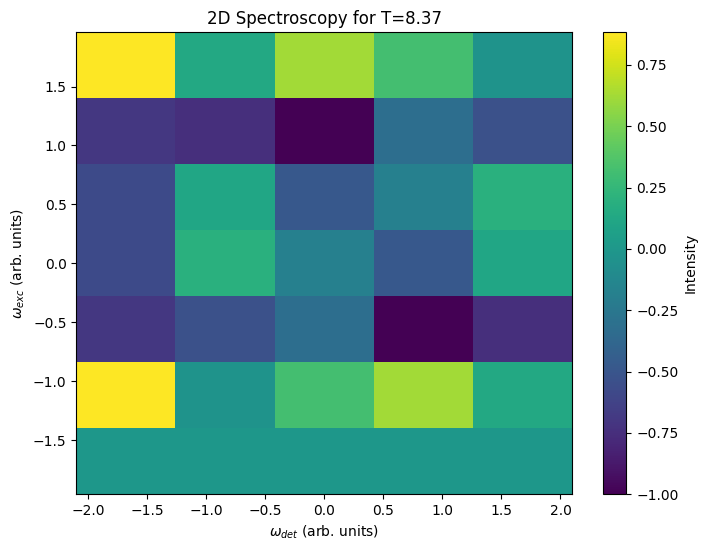

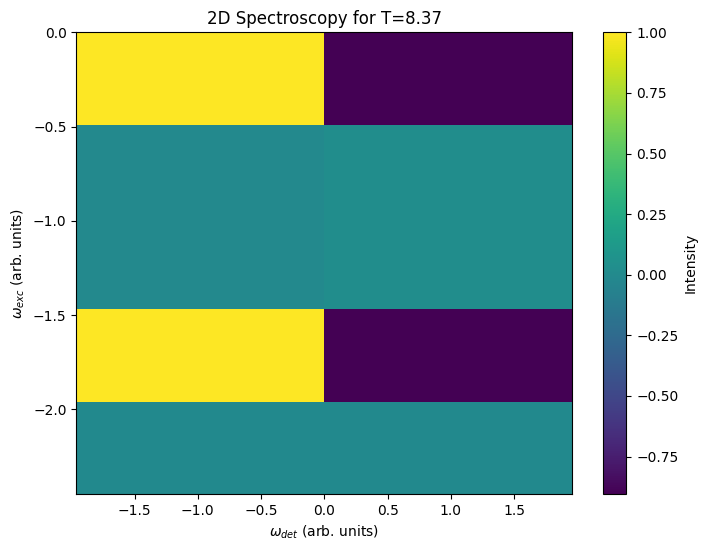

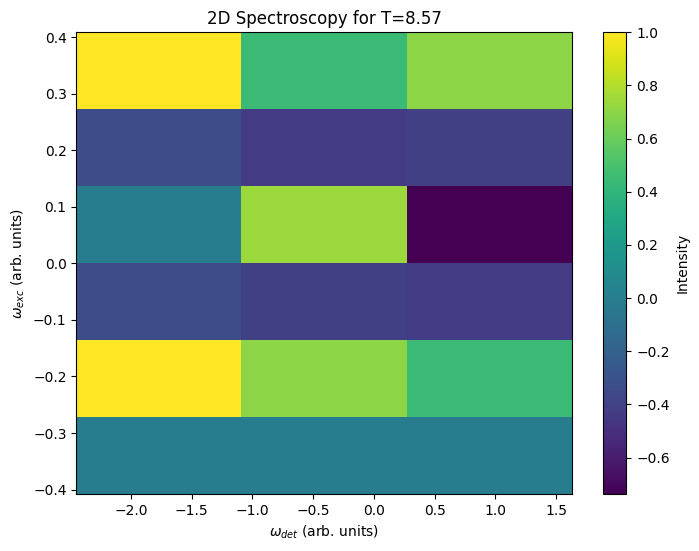

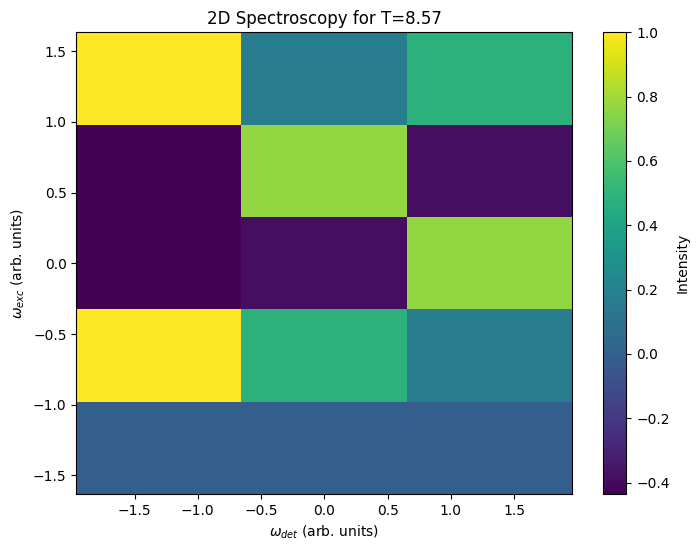

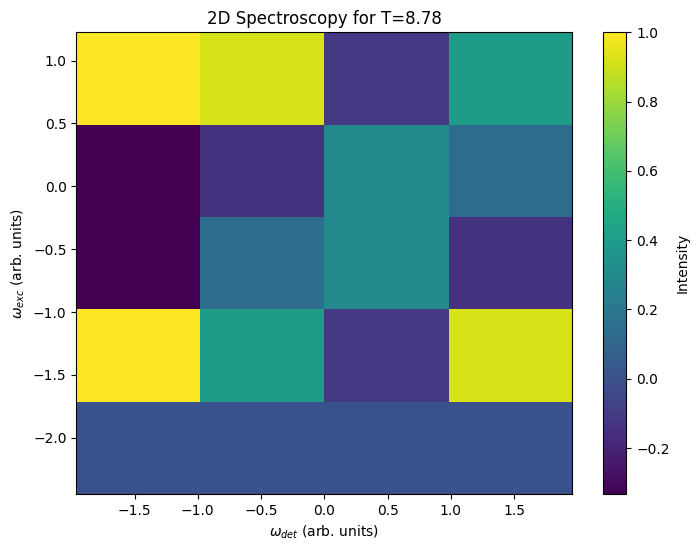

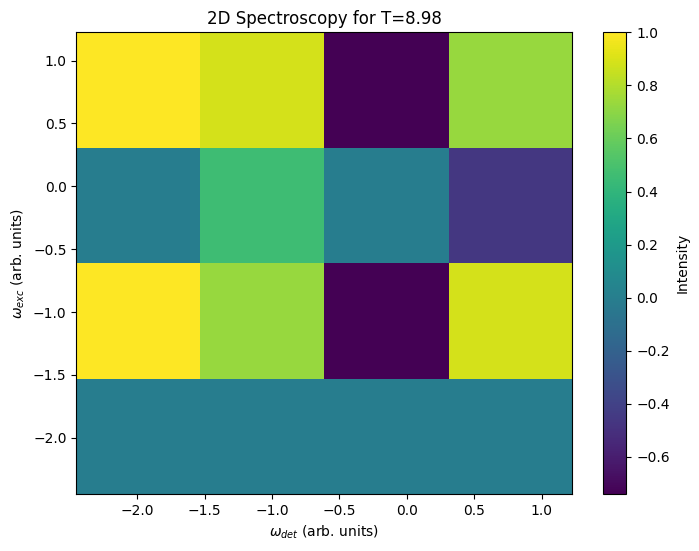

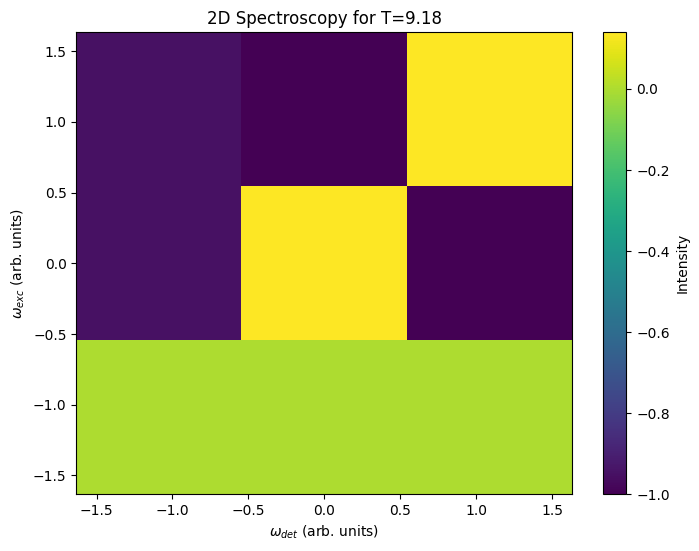

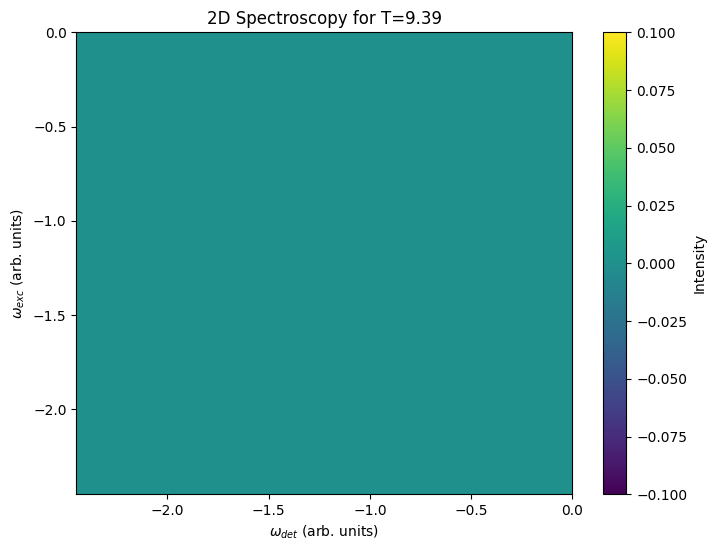

In [117]:
# Step 3: Process each entry by performing Fourier Transform
for idx, (T, (twoD_times, ts, taus)) in enumerate(two_d_array_dict.items()):
    # Only process every 10th entry
    if idx % 1 != 0:
        continue

    # Compute 2D Fourier Transform on the `twoD_times` data
    FT_data = np.fft.fft2(twoD_times)

    # Local ts and taus frequency axes
    t_freqs = np.fft.fftfreq(len(ts), d=(ts[1] - ts[0]))
    tau_freqs = np.fft.fftfreq(len(taus), d=(taus[1] - taus[0]))
    t_freqs_2D = t_freqs[:, np.newaxis]  # Reshape t_freqs into a column vector for broadcasting

    # Compute the intensity (A), using the imaginary part of FT data
    A = -t_freqs_2D * np.imag(FT_data)
    # Normalize A by its maximum absolute value for better visualization
    max_abs_A = np.max(np.abs(A))
    if max_abs_A != 0:  # Avoid division by zero
        A = A / max_abs_A

    # Step 3: Visualize the 2D spectroscopy data as a contour plot
#    plt.figure(figsize=(8, 6))
#    contour = plt.contourf(global_t_freqs, global_tau_freqs, A, cmap='viridis')  # Transpose A for proper orientation
#    plt.colorbar(contour, label="Intensity")
#    plt.title(f"2D Spectroscopy for T={T:.2f}")
#    plt.xlabel("$\\omega_{det}$ (arb. units)")
#    plt.ylabel("$\\omega_{exc}$ (arb. units)")
#    plt.show()

    plt.figure(figsize=(8, 6))
    extent = [t_freqs.min(), t_freqs.max(), tau_freqs.min(), tau_freqs.max()]
    plt.imshow(A, extent=extent, origin='lower', aspect='auto', cmap='viridis')  # Display A as an image
    plt.colorbar(label="Intensity")
    plt.title(f"2D Spectroscopy for T={T:.2f}")
    plt.xlabel("$\omega_{det}$ (arb. units)")
    plt.ylabel("$\omega_{exc}$ (arb. units)")
    plt.show()

In [108]:
# Step 1: Create global frequency axis for all entries
all_t_freqs = []
all_tau_freqs = []

for _, (_, ts, taus) in two_d_array_dict.items():
    if len(ts) > 2 and len(taus) > 2:  # Ensure valid data
        t_freqs = np.fft.fftfreq(len(ts), ts[1] - ts[0])  # Detection frequencies
        tau_freqs = np.fft.fftfreq(len(taus), taus[1] - taus[0])  # Excitation frequencies
        all_t_freqs.extend(t_freqs)
        all_tau_freqs.extend(tau_freqs)

# Take only unique frequencies to generate global frequency axes
global_t_freqs = np.fft.fftfreq(len(global_ts), d=(global_ts[1] - global_ts[0]))
global_tau_freqs = np.fft.fftfreq(len(global_taus), d=(global_taus[1] - global_taus[0]))

# Create global meshed frequency grid for plotting
X_global_freqs, Y_global_freqs = np.meshgrid(global_t_freqs, global_tau_freqs)

# Step 2: Process each entry by performing Fourier Transform
for idx, (T, (twoD_times, ts, taus)) in enumerate(two_d_array_dict.items()):
    if idx % 10 != 0:
        continue

    # Compute 2D Fourier Transform (complex coefficients)
    FT_data = np.fft.fft2(twoD_times)

    # Compute local frequency axes
    t_freqs = np.fft.fftfreq(len(ts), ts[1] - ts[0])
    tau_freqs = np.fft.fftfreq(len(taus), taus[1] - taus[0])

    # Initialize a global frequency-space array
    data = np.zeros(X_global_freqs.shape, dtype=complex)

    # Map local ts and taus to global Fourier frequencies using np.isclose
    ts_indices = [i for t in ts for i, f_t in enumerate(global_t_freqs) if
                  np.isclose(f_t, np.fft.fftfreq(len(ts), d=(ts[1] - ts[0]))[ts.index(t)])]
    taus_indices = [i for tau in taus for i, f_tau in enumerate(global_tau_freqs) if
                    np.isclose(f_tau, np.fft.fftfreq(len(taus), d=(taus[1] - taus[0]))[taus.index(tau)])]

    # Validate mapping
    if len(ts_indices) != len(ts) or len(taus_indices) != len(taus):
        print(
            f"Warning: Some ts or taus could not be mapped correctly for T={T}. Check frequency resolution or input data.")

    # Fill the global 2D Fourier space array with the local data
    for local_tau_idx, global_tau_idx in enumerate(taus_indices):
        for local_t_idx, global_t_idx in enumerate(ts_indices):
            if 0 <= global_tau_idx < data.shape[0] and 0 <= global_t_idx < data.shape[1]:
                # Assign the Fourier-transformed data
                data[global_tau_idx, global_t_idx] = twoD_times[local_tau_idx, local_t_idx]
            else:
                print(f"Skipping out-of-bounds index: ({global_tau_idx}, {global_t_idx}) for T={T}.")


    # Step 3: Normalize the FT data for intensity visualization (optional)
    intensity = np.abs(data)  # Magnitude of complex data
    max_intensity = np.max(intensity)
    if max_intensity != 0:  # Normalize
        intensity /= max_intensity

    # Step 4: Visualize the Fourier Transformed Data
    plt.figure(figsize=(10, 8))
    extent = [global_t_freqs[0], global_t_freqs[-1], global_tau_freqs[0], global_tau_freqs[-1]]
    plt.imshow(intensity, extent=extent, origin='lower', aspect='auto', cmap='viridis')
    plt.colorbar(label="Normalized Intensity")
    plt.title(f"2D Fourier Transform for T={T:.2f}")
    plt.xlabel("$\omega_{det}$ (Detection Frequency, arb. units)")
    plt.ylabel("$\omega_{exc}$ (Excitation Frequency, arb. units)")
    plt.show()

<>:67: SyntaxWarning: invalid escape sequence '\o'
<>:68: SyntaxWarning: invalid escape sequence '\o'
<>:67: SyntaxWarning: invalid escape sequence '\o'
<>:68: SyntaxWarning: invalid escape sequence '\o'
/tmp/ipykernel_39076/2335815836.py:67: SyntaxWarning: invalid escape sequence '\o'
  plt.xlabel("$\omega_{det}$ (Detection Frequency, arb. units)")
/tmp/ipykernel_39076/2335815836.py:68: SyntaxWarning: invalid escape sequence '\o'
  plt.ylabel("$\omega_{exc}$ (Excitation Frequency, arb. units)")
/tmp/ipykernel_39076/2335815836.py:67: SyntaxWarning: invalid escape sequence '\o'
  plt.xlabel("$\omega_{det}$ (Detection Frequency, arb. units)")
/tmp/ipykernel_39076/2335815836.py:68: SyntaxWarning: invalid escape sequence '\o'
  plt.ylabel("$\omega_{exc}$ (Excitation Frequency, arb. units)")


IndexError: index 41 is out of bounds for axis 1 with size 41

<>:79: SyntaxWarning: invalid escape sequence '\o'
<>:80: SyntaxWarning: invalid escape sequence '\o'
<>:79: SyntaxWarning: invalid escape sequence '\o'
<>:80: SyntaxWarning: invalid escape sequence '\o'
/tmp/ipykernel_39076/939760212.py:79: SyntaxWarning: invalid escape sequence '\o'
  plt.xlabel("$\omega_{det}$ (arb. units)")
/tmp/ipykernel_39076/939760212.py:80: SyntaxWarning: invalid escape sequence '\o'
  plt.ylabel("$\omega_{exc}$ (arb. units)")


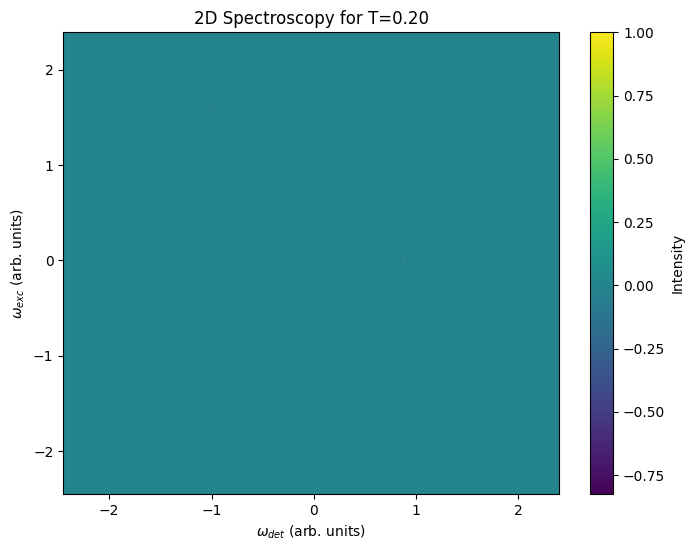

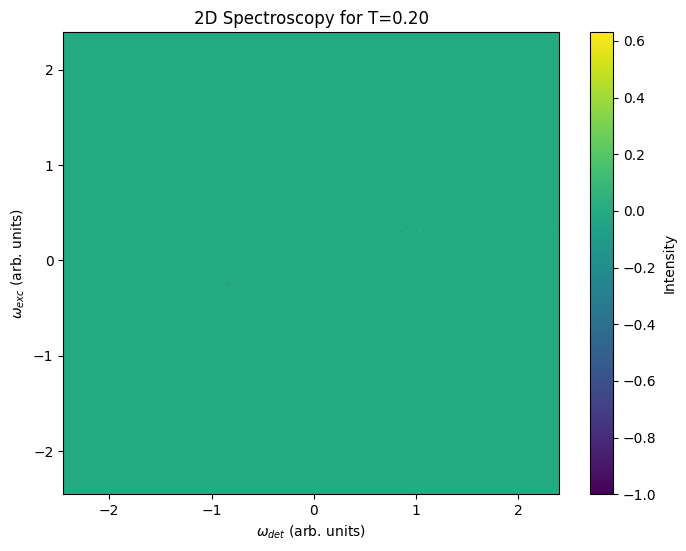

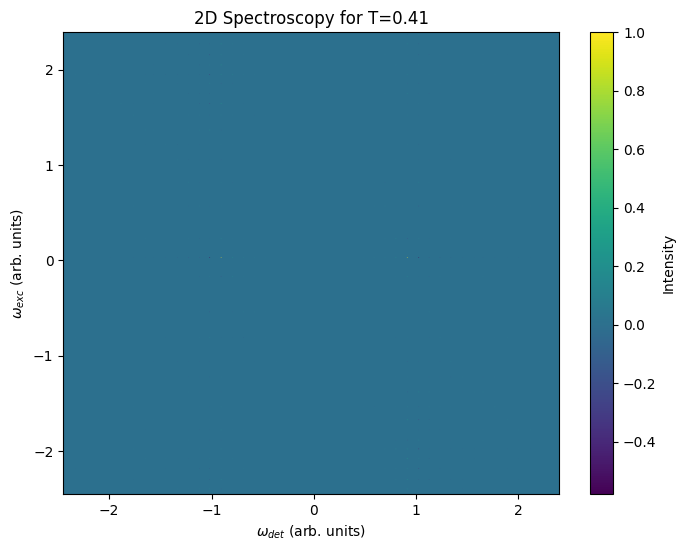

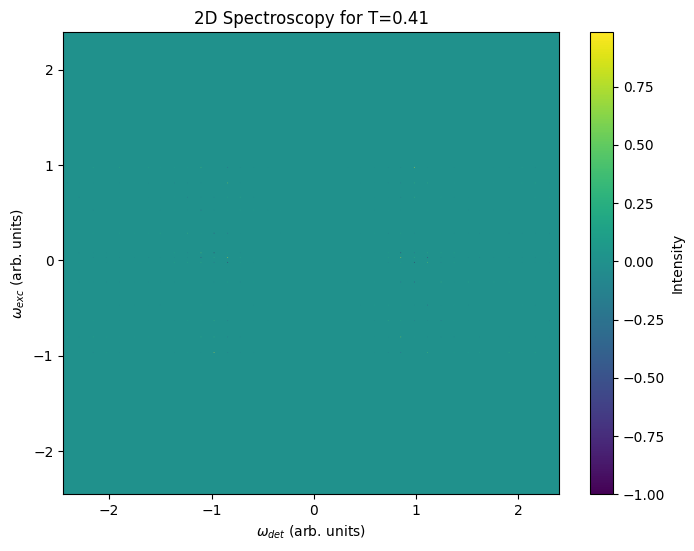

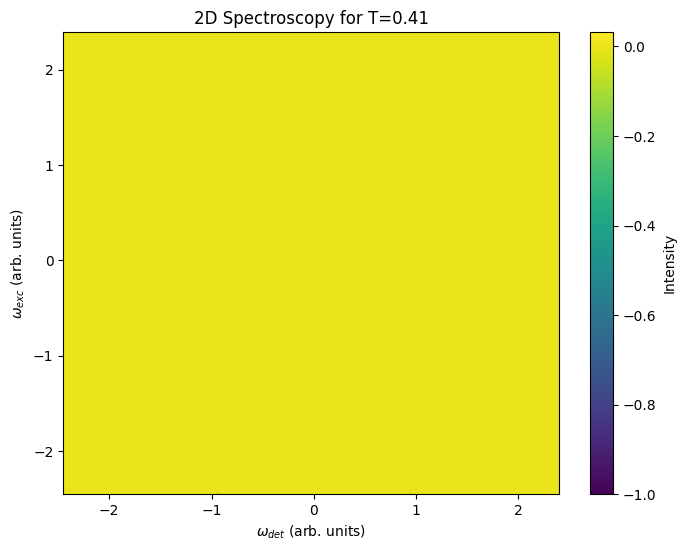

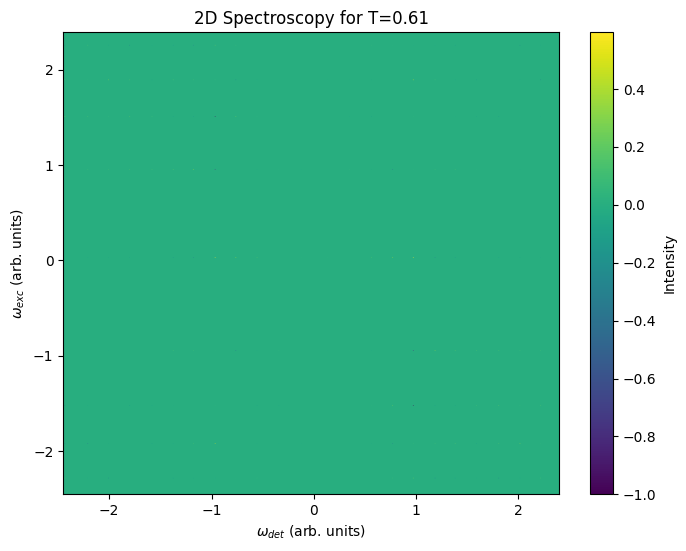

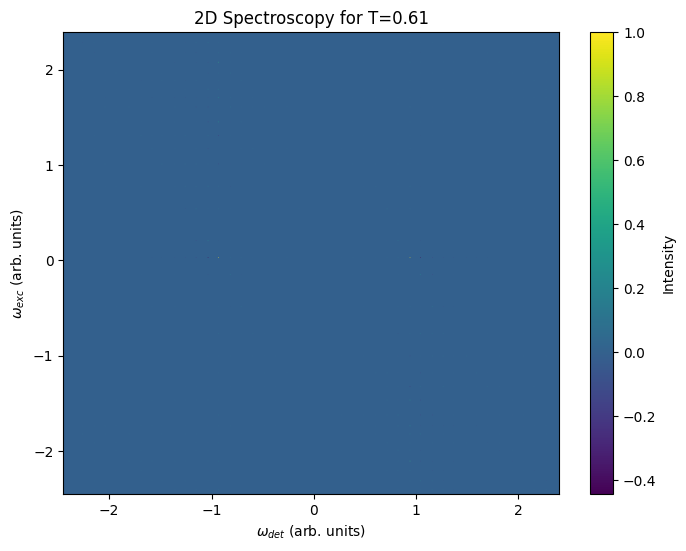

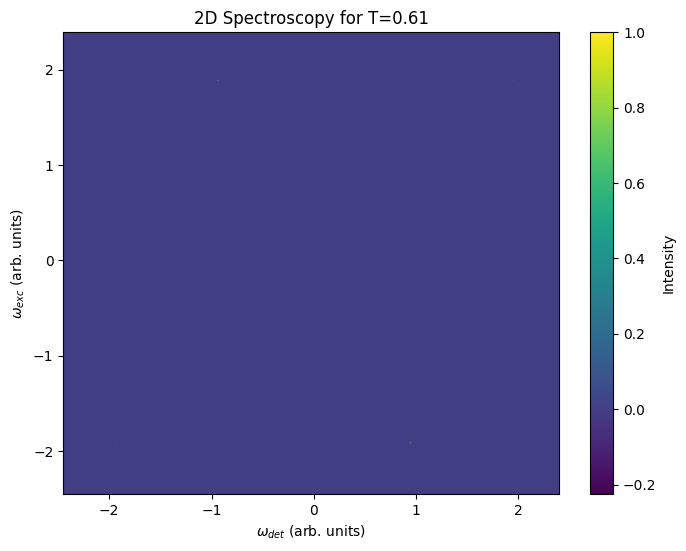

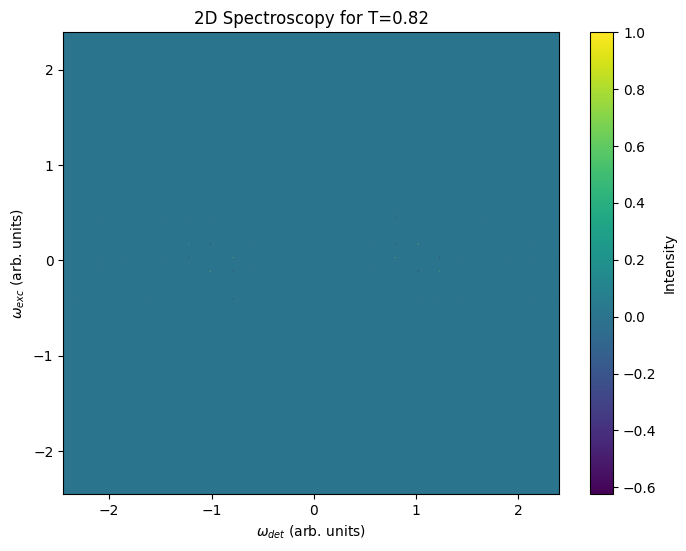

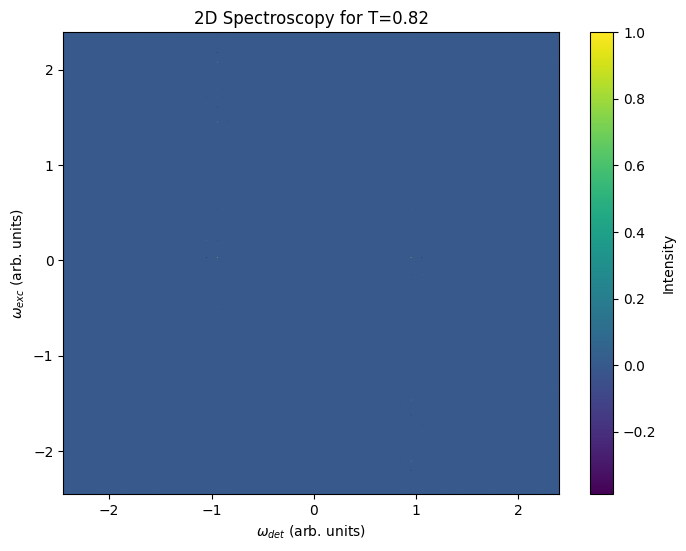

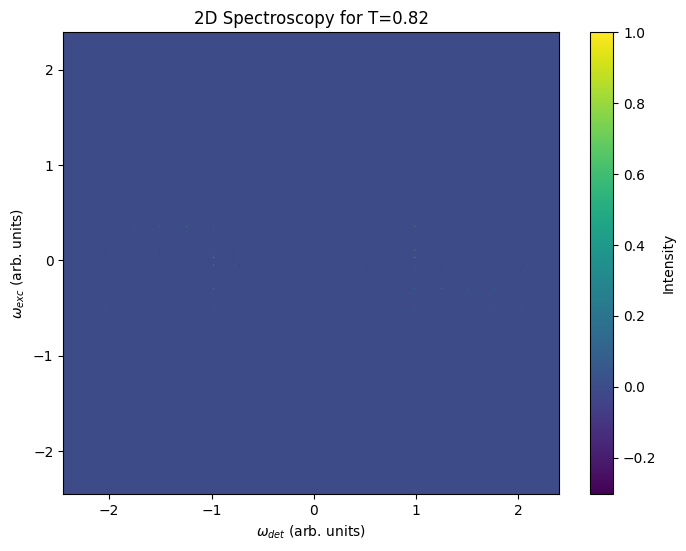

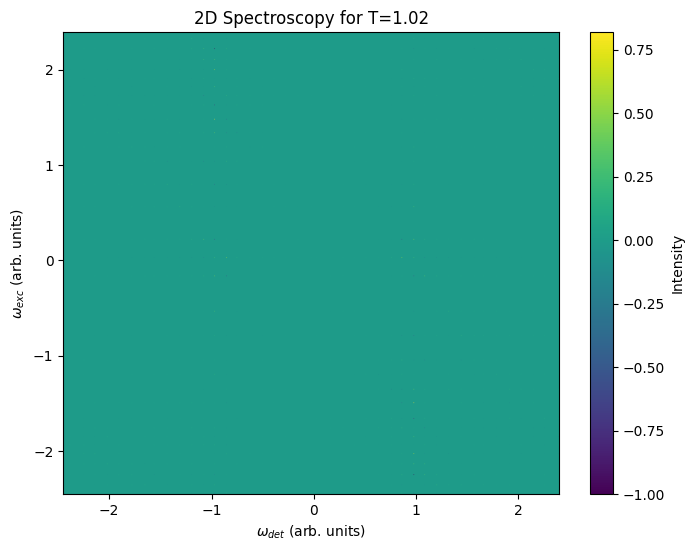

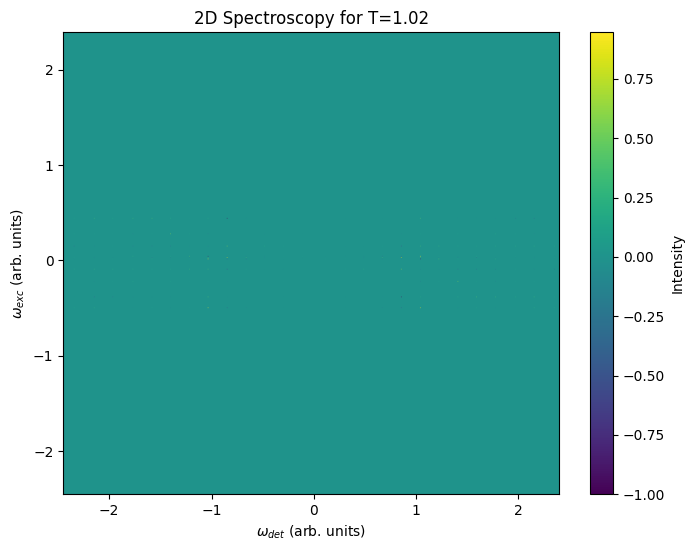

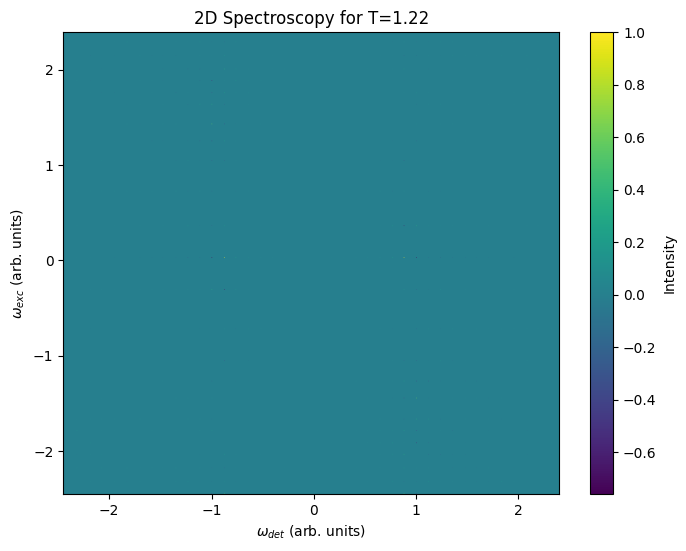

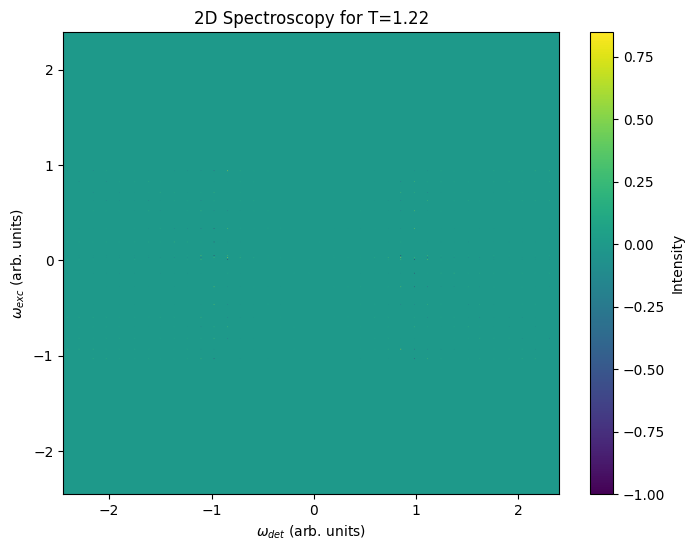

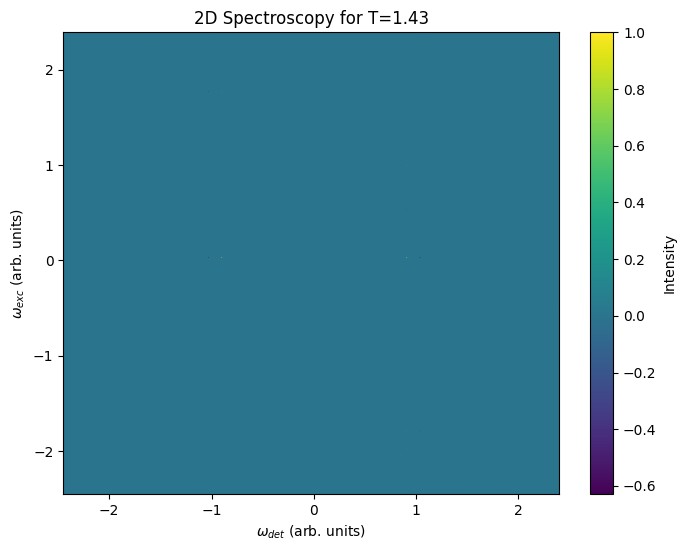

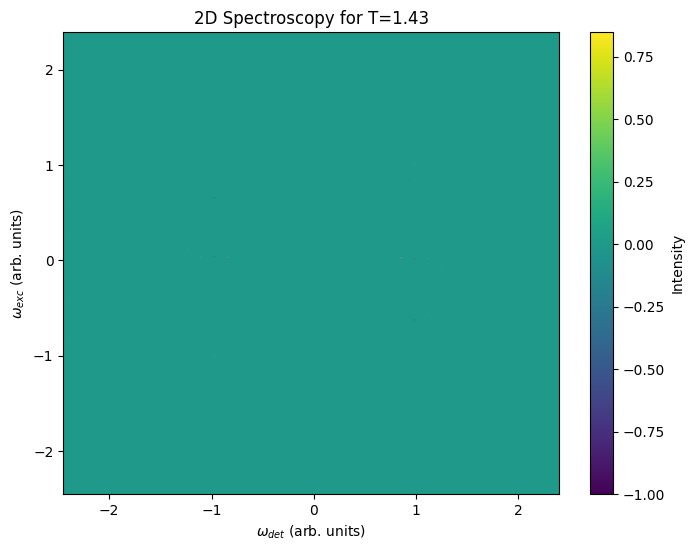

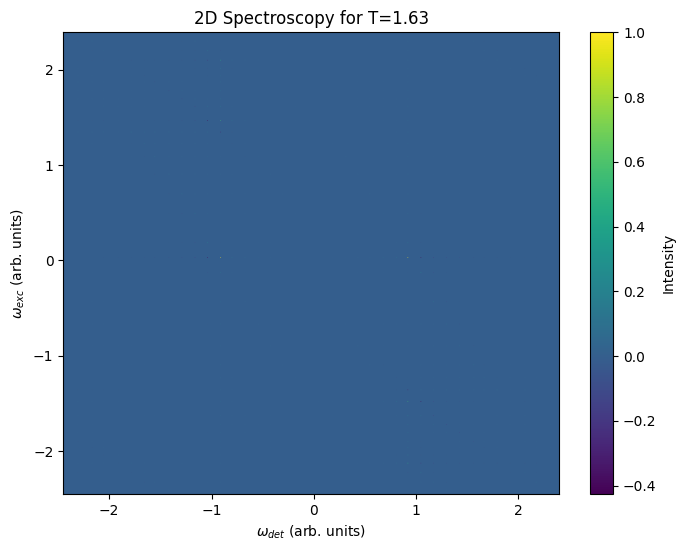

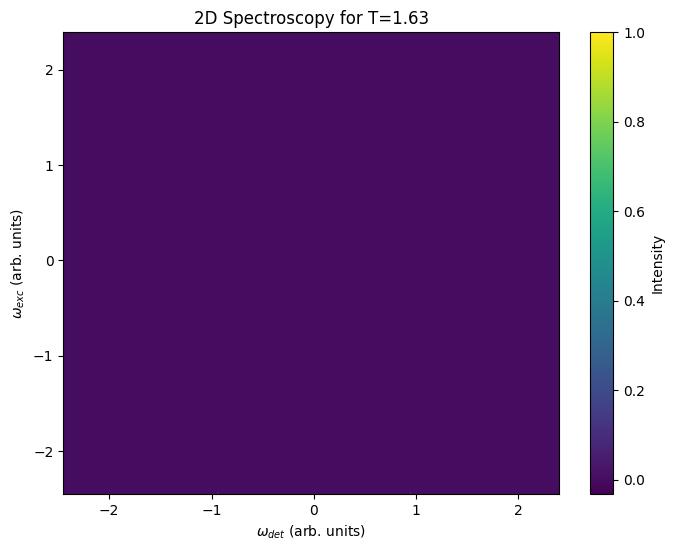

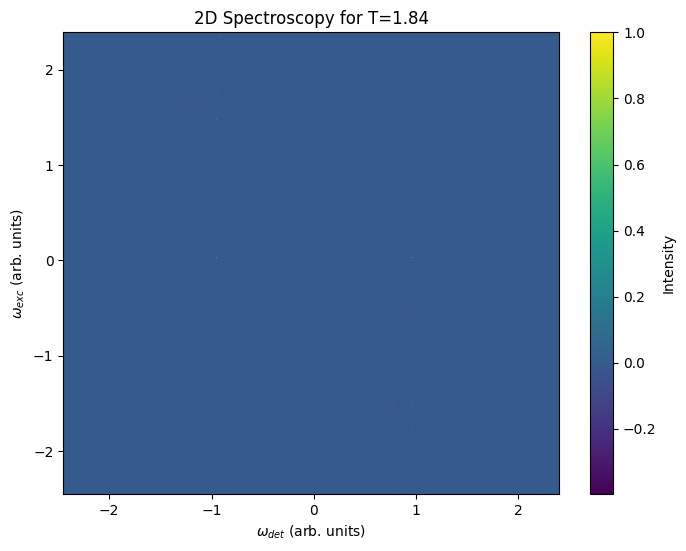

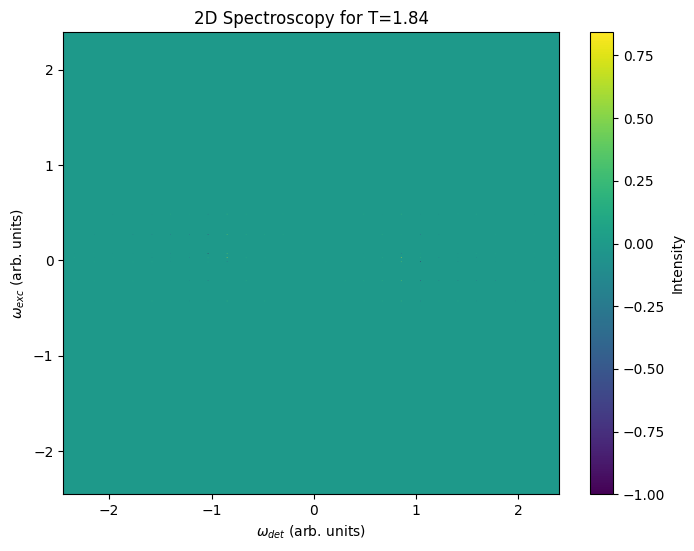

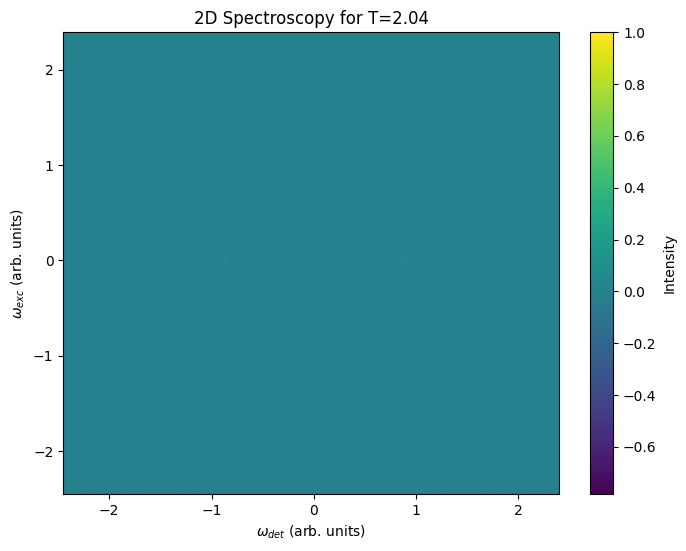

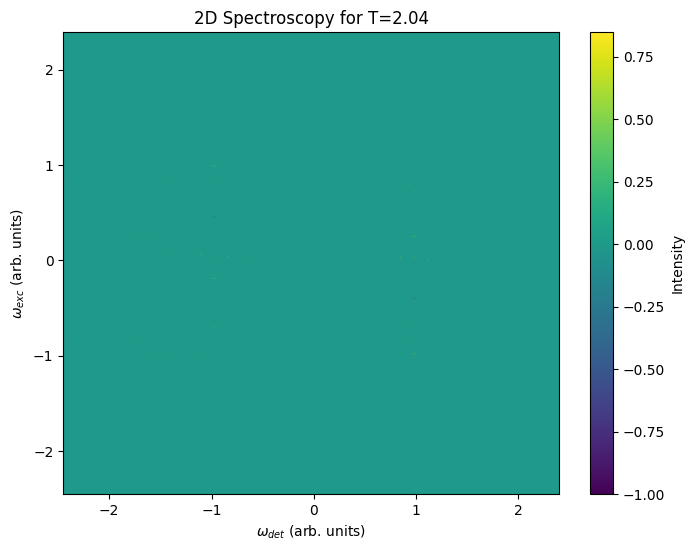

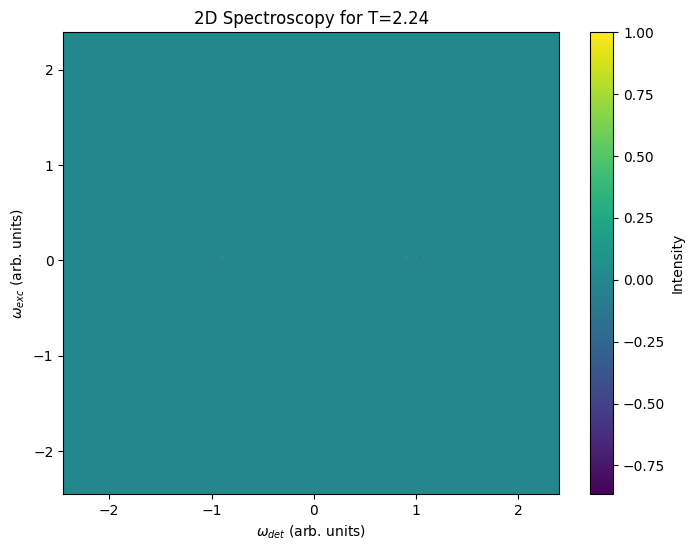

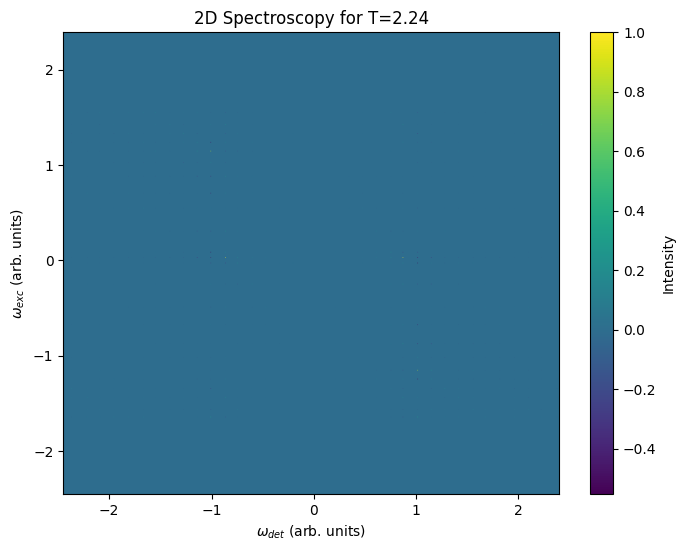

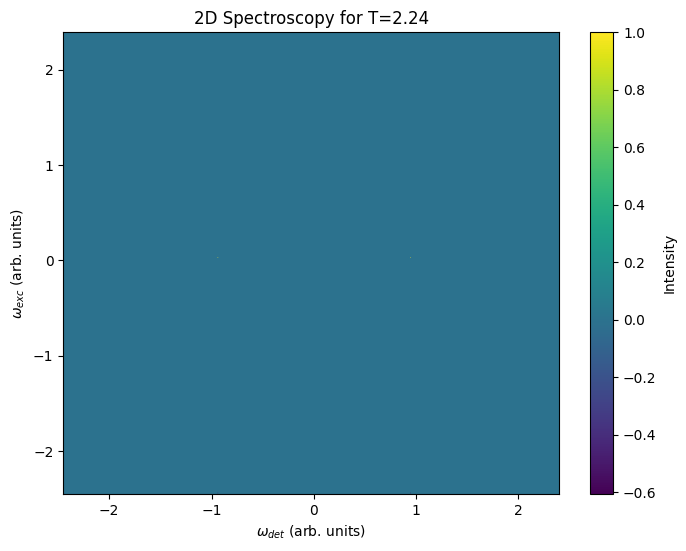

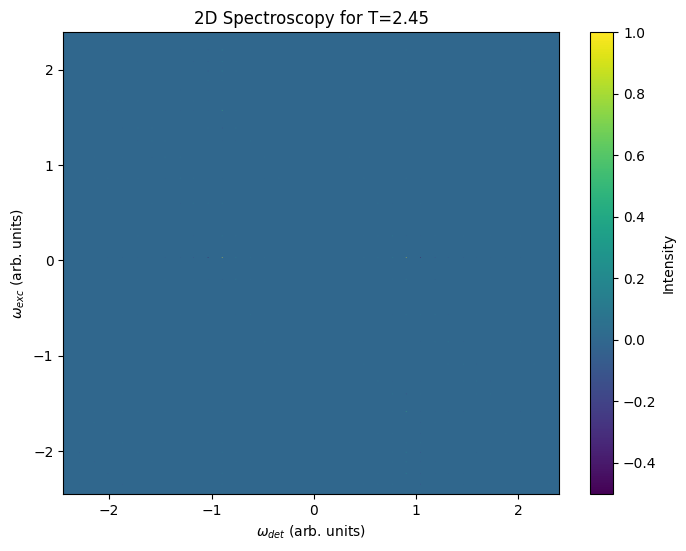

/tmp/ipykernel_39076/939760212.py:79: SyntaxWarning: invalid escape sequence '\o'
  plt.xlabel("$\omega_{det}$ (arb. units)")
/tmp/ipykernel_39076/939760212.py:80: SyntaxWarning: invalid escape sequence '\o'
  plt.ylabel("$\omega_{exc}$ (arb. units)")


IndexError: index 0 is out of bounds for axis 0 with size 0

In [96]:
# Step 1: Create a global grid for t_freqs and tau_freqs
all_t_freqs = []
all_tau_freqs = []
FT_data_dict = {}
for T, (twoD_times, ts, taus) in two_d_array_dict.items():
    if len(ts) > 2 and len(taus) > 2:  # Ensure valid data
        t_freqs = np.fft.fftfreq(len(ts), ts[1] - ts[0])
        tau_freqs = np.fft.fftfreq(len(taus), taus[1] - taus[0])
        # Collect all frequencies (including negative) for later processing
        all_t_freqs.extend(t_freqs)
        all_tau_freqs.extend(tau_freqs)

# Take only unique frequencies to generate global frequency axes
global_t_freqs = sorted(np.unique(all_t_freqs))
global_tau_freqs = sorted(np.unique(all_tau_freqs))

# Create a global grid (meshed grid for 2D plotting)
global_t_freqs, global_tau_freqs = np.meshgrid(global_t_freqs, global_tau_freqs)

#print(global_t_freqs, global_tau_freqs)

# Step 2: Process each 2D dataset
for idx, (T, (twoD_times, ts, taus)) in enumerate(two_d_array_dict.items()):
    # Only process every entry, currently set to process all
    if idx % 1 != 0:
        continue

    # Compute the 2D Fast Fourier Transform
    FT_data = np.fft.fft2(twoD_times)  # Complex Fourier coefficients

    # Compute the local frequency axes for ts and taus
    t_freqs = np.fft.fftfreq(len(ts), ts[1] - ts[0])
    tau_freqs = np.fft.fftfreq(len(taus), taus[1] - taus[0])

    # Map local frequencies to global grid indices
    ts_indices = [np.where(global_t_freqs[0] == t)[0][0] for t in t_freqs]  # `global_t_freqs[0]` since it's 2D
    taus_indices = [np.where(global_tau_freqs[:, 0] == tau)[0][0] for tau in
                tau_freqs]

    # Initialize a global grid for storing FT data
    FT_data_full = np.full(global_t_freqs.shape, np.nan + 0j, dtype=complex)  # or np.complex128

    # Populate global grid with FT data safely
    for i, tau_idx in enumerate(taus_indices):
        if tau_idx >= FT_data_full.shape[0]:
            continue  # Skip out-of-bounds indices for tau
        for j, t_idx in enumerate(ts_indices):
            if t_idx >= FT_data_full.shape[1]:
                continue  # Skip out-of-bounds indices for t
            FT_data_full[tau_idx, t_idx] = FT_data[j, i]

    # Reshape t_freqs for broadcasting, to allow element-wise multiplication
    # Broadcasting is required to match the dimensions of `t_freqs_2D` (1D array reshaped to column)
    # to the dimensions of `FT_data_full` (2D array). This allows operations between the t_freqs
    # and the corresponding values in the Fourier data for visualization.
    t_freqs_2D = global_t_freqs[:]

    # Compute the intensity (A), using the imaginary part of FT data
    A = -t_freqs_2D * np.imag(FT_data_full)
    # Normalize A by its maximum absolute value for better visualization
    max_abs_A = np.max(np.abs(A))
    if max_abs_A != 0:  # Avoid division by zero
        A = A / max_abs_A

    # Step 3: Visualize the 2D spectroscopy data as a contour plot
#    plt.figure(figsize=(8, 6))
#    contour = plt.contourf(global_t_freqs, global_tau_freqs, A, cmap='viridis')  # Transpose A for proper orientation
#    plt.colorbar(contour, label="Intensity")
#    plt.title(f"2D Spectroscopy for T={T:.2f}")
#    plt.xlabel("$\\omega_{det}$ (arb. units)")
#    plt.ylabel("$\\omega_{exc}$ (arb. units)")
#    plt.show()

    plt.figure(figsize=(8, 6))
    extent = [global_t_freqs.min(), global_t_freqs.max(), global_tau_freqs.min(), global_tau_freqs.max()]
    plt.imshow(A, extent=extent, origin='lower', aspect='auto', cmap='viridis')  # Display A as an image
    plt.colorbar(label="Intensity")
    plt.title(f"2D Spectroscopy for T={T:.2f}")
    plt.xlabel("$\omega_{det}$ (arb. units)")
    plt.ylabel("$\omega_{exc}$ (arb. units)")
    plt.show()

In [ ]:
# Perform computation of A = -t_freqs * IM(FT_data) for each T
for idx, (T, (twoD_times, ts, taus)) in enumerate(two_d_array_dict.items()):
    # Only plot every 10th entry
    if idx % 10 != 0:
        continue

    # Compute the 2D Fast Fourier Transform
    FT_data = np.fft.fft2(twoD_times)  # Complex Fourier coefficients
    # Shift zero frequency component to the center
    FT_data_shifted = np.fft.fftshift(FT_data)

    # Compute frequency arrays for the t-axis
    if len(ts) > 2:
        t_freqs = np.fft.fftshift(np.fft.fftfreq(len(ts), ts[1] - ts[0]))
    else:
        continue

    # Compute frequency arrays for the tau-axis
    if len(taus) > 2:
        tau_freqs = np.fft.fftshift(np.fft.fftfreq(len(taus), taus[1] - taus[0]))
    else:
        continue

    # Ensure no mismatch between tau_freqs and FT_data dimensions
    assert len(tau_freqs) == FT_data_shifted.shape[1], "Mismatch between tau_freqs and FT_data dimensions!"

    # Identify positive frequencies in tau_freqs
    positive_indices_tau = np.where(tau_freqs >= 0)[0]
    negative_indices_tau = len(tau_freqs) - positive_indices_tau - 1
    positive_part_tau = FT_data_shifted[:, positive_indices_tau]
    negative_part_tau = FT_data_shifted[:, negative_indices_tau]  # Mirrored negative parts (correct symmetry)

    # Combine data: average the contributions of positive and negative parts
    combined_data_tau = (positive_part_tau + negative_part_tau) / 2

    # Update tau_freqs to only positive frequencies
    tau_freqs_positive = tau_freqs[positive_indices_tau]

    # Identify positive frequencies in t_freqs
    positive_indices_t = np.where(t_freqs >= 0)[0]
    negative_indices_t = len(t_freqs) - positive_indices_t - 1
    positive_part_t = combined_data_tau[positive_indices_t, :]
    negative_part_t = combined_data_tau[negative_indices_t, :]

    # Combine data: average the contributions of positive and negative parts for t_freqs
    combined_data = (positive_part_t + negative_part_t) / 2

    # Update t_freqs to only positive frequencies
    t_freqs_positive = t_freqs[positive_indices_t]

    # Now operate on combined data
    # Fix broadcasting issue by reshaping the positive frequencies
    t_freqs_2D_positive = t_freqs_positive[:, np.newaxis]  # Reshape for broadcasting
    safe_t_freqs_2D_pos = np.where(t_freqs_2D_positive == 0, 1, t_freqs_2D_positive)  # Avoid division by zero

    # Compute A
    A = -t_freqs_2D_positive * np.imag(combined_data)

    # Normalize A by its maximum absolute value
    max_abs_A = np.max(np.abs(A))
    if max_abs_A != 0:  # Avoid division by zero
        A = A / max_abs_A

    # Plot A with updated tau_freqs_positive
    plt.figure(figsize=(8, 6))
    plt.contourf(
        t_freqs_positive,  # x-axis: ω_det
        tau_freqs_positive,  # y-axis: ω_exc (positive frequencies only)
        A.T,
        cmap="coolwarm"
    )

    plt.colorbar()
    plt.title(f"2D spectroscopy for T={T:.2f}")
    plt.xlabel("$\\omega_{det}$ arb. units")
    plt.ylabel("$\\omega_{exc} (> 0)$ arb. units")  # Highlight positive frequencies
    plt.show()

In [ ]:
from scipy.interpolate import griddata
import numpy as np
import matplotlib.pyplot as plt

# Initialize empty lists to store frequency axes and spectra
all_t_freqs_pos = []
all_tau_freqs_pos = []
all_spectra = []  # To store the processed spectra for each T

for idx, (T, (twoD_times, ts, taus)) in enumerate(two_d_array_dict.items()):
    # Perform Fourier Transform and extract positive frequencies
    FT_data = np.fft.fft2(twoD_times)  # Complex Fourier coefficients
    FT_data_shifted = np.fft.fftshift(FT_data)

    # Compute t and tau frequency arrays
    if len(ts) > 2:
        t_freqs = np.fft.fftshift(np.fft.fftfreq(len(ts), ts[1] - ts[0]))
    else:
        continue

    if len(taus) > 2:
        tau_freqs = np.fft.fftshift(np.fft.fftfreq(len(taus), taus[1] - taus[0]))
    else:
        continue

    # Ensure no mismatch in dimensions
    assert len(tau_freqs) == FT_data_shifted.shape[1], "Mismatch between tau_freqs and FT_data dimensions!"

    # Extract positive t and tau frequencies
    positive_indices_tau = np.where(tau_freqs >= 0)[0]
    positive_indices_t = np.where(t_freqs >= 0)[0]

    positive_part_tau = FT_data_shifted[:, positive_indices_tau]
    tau_freqs_positive = tau_freqs[positive_indices_tau]

    positive_part_t = positive_part_tau[positive_indices_t, :]
    t_freqs_positive = t_freqs[positive_indices_t]

    # Normalize the combined data
    t_freqs_2D_positive = t_freqs_positive[:, np.newaxis]  # Reshape for operation
    A = -t_freqs_2D_positive * np.imag(positive_part_t)

    # Normalize the spectrum for this T
    max_abs_A = np.max(np.abs(A))
    if max_abs_A != 0:  # Avoid division by zero
        A = A / max_abs_A

    # Append frequencies and the spectrum
    all_t_freqs_pos.append(t_freqs_positive)
    all_tau_freqs_pos.append(tau_freqs_positive)
    all_spectra.append(A)

# Step 1: Create global grid by merging all frequency axes
global_t_freqs = np.unique(np.concatenate(all_t_freqs_pos))  # Unique sorted frequencies
global_tau_freqs = np.unique(np.concatenate(all_tau_freqs_pos))  # Unique sorted frequencies
global_t_grid, global_tau_grid = np.meshgrid(global_t_freqs, global_tau_freqs)

# Debug: Print shapes of the global grid
print(f"Global t grid shape: {global_t_grid.shape}")
print(f"Global tau grid shape: {global_tau_grid.shape}")

# Step 2: Initialize a matrix to store the integrated result
integrated_result = np.zeros_like(global_t_grid, dtype=np.float64)

# Step 3: Interpolate spectra onto the global grid
for t_freqs_positive, tau_freqs_positive, A in zip(all_t_freqs_pos, all_tau_freqs_pos, all_spectra):
    # Flatten the t and tau frequency arrays to use with griddata
    points = np.array(np.meshgrid(t_freqs_positive, tau_freqs_positive)).reshape(2, -1).T
    A_interpolated = griddata(
        points, A.ravel(), (global_t_grid, global_tau_grid), method="linear", fill_value=0
    )

    # Accumulate the interpolated result
    integrated_result += A_interpolated

# Normalize the integrated result after accumulation
max_abs_integrated = np.max(np.abs(integrated_result))
if max_abs_integrated != 0:  # Avoid division by zero
    integrated_result /= max_abs_integrated

# Debug: Print the shape of the integrated result
print(f"Integrated result shape: {integrated_result.shape}")

plt.figure(figsize=(8, 6))
plt.imshow(
    integrated_result.T,  # Transpose to align axes correctly
    aspect='auto',  # Adjust the aspect ratio to match the data
    extent=(global_t_freqs[0], global_t_freqs[-1], global_tau_freqs[0], global_tau_freqs[-1]),
    origin='lower',  # Place the smallest values at the bottom left corner
    cmap="coolwarm"
)
plt.colorbar(label="Integrated Amplitude")
plt.title("Integrated Spectrum Over T")
plt.xlabel("Detection Frequency (ω_det)")
plt.ylabel("Excitation Frequency (ω_exc)")
plt.show()


In [ ]:
plt.figure(figsize=(8, 6))
plt.pcolormesh(global_t_freqs, global_tau_freqs, integrated_result, cmap="coolwarm", shading="auto")
plt.colorbar(label="Integrated Amplitude")
plt.title("Integrated Spectrum Over T")
plt.xlabel("Detection Frequency (ω_det)")
plt.ylabel("Excitation Frequency (ω_exc)")
plt.show()

In [ ]:
import numpy as np
from scipy.fft import fft, fftshift

# Generate a simple signal
x = np.linspace(0, 2*np.pi, 128)
y = np.sin(x)

# Compute the FFT
Y = fft(y)

# Shift the FFT
Y_shifted = fftshift(Y)

# Compare
print(Y[0:5]) # Original FFT output
print(Y_shifted[0:5]) # After fftshift

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.fft import fft, fftshift

# Generate a complex signal
sample_rate = 1000
T = 1/sample_rate
t = np.linspace(0, 1.0, int(1/T), endpoint=False)
y = np.sin(50 * 2 * np.pi * t) + 0.5 * np.sin(80 * 2 * np.pi * t)

# Compute and shift FFT
Y = fft(y)
Y_shifted = fftshift(Y)
xf = np.linspace(-sample_rate/2, sample_rate/2, len(y))

# Plot
plt.figure()
plt.plot(xf, np.imag(Y))
plt.title('Shifted Frequency Spectrum')
plt.xlabel('Frequency (Hz)')
plt.ylabel('Magnitude')
plt.show()

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# Sample data (x_vals and y_vals)
x_vals = np.linspace(0, 10, 1000)  # Example time or space domain
y_vals = np.exp(-0.5 * ((x_vals - 5) / 1)**2)  # Gaussian centered at 5 with std dev = 1
y_vals = np.sign(np.sin(2 * np.pi * 1 * x_vals))  # Square wave with 1 Hz frequency

# Step 1: Compute the Fourier Transform using numpy's fft.fft
ft_vals = np.fft.fft(y_vals)

# Step 2: Compute the corresponding frequency values
delta_x = x_vals[1] - x_vals[0]  # spacing between data points
sampling_rate = 1 / delta_x

# Frequencies associated with the Fourier Transform
n = len(x_vals)  # number of points
freq_vals = np.fft.fftfreq(n, delta_x)  # Frequencies for the DFT

# Step 3: Only keep the positive frequencies (and the corresponding FFT values)
# Positive frequencies are from index 0 to n//2 (inclusive) in the FFT output
positive_freqs = freq_vals[:n//2]
positive_ft_vals = ft_vals[:n//2]

# Step 4: Plot the results (Magnitude of the FT for positive frequencies)
plt.figure(figsize=(10, 5))

# Plot the magnitude of the FT for positive frequencies
plt.subplot(1, 2, 1)
plt.plot(positive_freqs, np.abs(positive_ft_vals))
plt.title('Magnitude of Fourier Transform (Positive Frequencies)')
plt.xlabel('Frequency (Hz)')
plt.ylabel('Amplitude')

# Plot the original data
plt.subplot(1, 2, 2)
plt.plot(x_vals, y_vals)
plt.title('Original Data')
plt.xlabel('Time')
plt.ylabel('Amplitude')

plt.tight_layout()
plt.show()

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# Create a 2D grid
x_vals = np.linspace(-10, 10, 256)  # X axis
y_vals = np.linspace(-10, 10, 256)  # Y axis
X_vals, Y_vals = np.meshgrid(x_vals, y_vals)  # Create a 2D grid of coordinates

# Choose any 2D function for Y_vals
Y_vals = np.sin(2 * np.pi * 1 * X_vals) * np.sin(2 * np.pi * 1 * Y_vals)  # Example: 2D sine wave
#Y_vals = np.sign(np.sin(2 * np.pi * X_vals)) * np.sign(np.sin(2 * np.pi * Y_vals))

# Step 1: Compute the 2D Fourier Transform using numpy's fft2
FT_vals = np.fft.fft2(Y_vals)

# Step 2: Shift the zero frequency component to the center
FT_vals_shifted = np.fft.fftshift(FT_vals)

# Step 3: Compute the corresponding frequency values for both axes
delta_x = x_vals[1] - x_vals[0]
delta_y = y_vals[1] - y_vals[0]
freq_x = np.fft.fftfreq(len(x_vals), delta_x)  # Frequencies for the X axis
freq_y = np.fft.fftfreq(len(y_vals), delta_y)  # Frequencies for the Y axis
freq_x, freq_y = np.meshgrid(freq_x, freq_y)  # Create a 2D meshgrid for the frequencies

# Step 5: Plot the results (Magnitude of the FT for positive frequencies)
magnitude = np.abs(FT_vals_shifted)

# Plot the magnitude of the Fourier Transform (log scale for better visualization)
plt.figure(figsize=(8, 6))
plt.imshow(np.log(1 + magnitude), extent=(freq_x.min(), freq_x.max(), freq_y.min(), freq_y.max()))
plt.title('Magnitude of 2D Fourier Transform (Positive Frequencies)')
plt.xlabel('Frequency in X (Hz)')
plt.ylabel('Frequency in Y (Hz)')
plt.colorbar(label='Magnitude')
plt.tight_layout()
plt.show()
